<a href="https://colab.research.google.com/github/norifujimura/breathing-st-george-colab/blob/main/pg_gan_512px.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PG-GAN 512x512

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/pg-gan

/content/drive/MyDrive/ColabNotebooks/pg-gan


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Dec 14 21:32:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

 PGGAN （256px Progressive Growing）

ランタイムの初期化（推奨）

In [ ]:
# ランタイム初期化（推奨）
import os, gc, torch
gc.collect()
torch.cuda.empty_cache()

依存ライブラリのインストール

In [ ]:
!pip install opencv-python torch torchvision tqdm

動画から画像を抽出（512px 正方形）

In [ ]:
import cv2
import os

# ---- 設定 ----
VIDEO_PATH = "stainedglass/stainedglass-720p.mp4"  # あなたの動画をここに置く
OUTPUT_DIR = "stainedglass/512x1200/frames"
TARGET_SIZE = 512
FPS_EXTRACT = 4   # ← ここを変更すれば枚数を増減可能

os.makedirs(OUTPUT_DIR, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
orig_fps = cap.get(cv2.CAP_PROP_FPS)

frame_interval = max(1, int(orig_fps / FPS_EXTRACT))

count = 0
saved = 0

print(f"Original FPS: {orig_fps}, extracting {FPS_EXTRACT} fps")

while True:
    ret = cap.grab()
    if not ret:
        break

    # 必要分だけフレーム抽出
    if count % frame_interval == 0:
        ret, frame = cap.retrieve()
        if not ret:
            break

        h, w, _ = frame.shape
        size = min(h, w)
        start_x = (w - size) // 2
        start_y = (h - size) // 2
        square = frame[start_y:start_y + size, start_x:start_x + size]

        resized = cv2.resize(square, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)

        out_path = f"{OUTPUT_DIR}/frame_{saved:05d}.png"
        cv2.imwrite(out_path, resized)
        saved += 1

    count += 1

cap.release()

print(f"抽出完了：{saved} 枚の画像を保存しました")

Original FPS: 25.326239745161043, extracting 4 fps
抽出完了：1278 枚の画像を保存しました


Dataset の準備（PGGAN用）

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob

DATA_DIR = "jorge/illusts/512x980/frames"
'''
transform = transforms.Compose([
    transforms.Resize((512,512)),     # ★ 必須 ★
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
'''
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(glob.glob(folder + "/*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

dataset = ImageFolderDataset(DATA_DIR)
print("画像数：", len(dataset))

画像数： 980


DataLoader（安定設定）
PGGAN 初期フェーズは画像が小さいため
batch=32〜64 でも動きますが、
品質を優先して batch=32 を推奨。

In [4]:
loader = DataLoader(
    dataset,
    batch_size=4, # 256:8 512:4
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print("loader OK, total images:", len(dataset))

loader OK, total images: 980


 ここまでが「データ準備フェーズ」

Generator & Discriminator
PGGAN のコアアイデア：   
	1.	4×4 から始める.  
	2.	各解像度で block を追加.  
	3.	既存ネットと新block の間を fade-in（α）で連結.  
	4.	toRGB / fromRGB を解像度ごとに用意.  
	5.	最終的に 256×256 に到達.  

Resolution
Channels.  
4×4
512.  
8×8
512.  
16×16
512.  
32×32
256.  
64×64
128.  
128×128
64.  
256×256
32.  


PixelNorm（G用）

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, eps=1e-8):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + eps)

Equalized Learning Rate 層（PGGAN特有）
この技術により、PGGAN の安定性が劇的に向上します。

In [6]:
import math

class EqualizedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride=1, padding=0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_ch, in_ch, kernel, kernel))
        self.bias = nn.Parameter(torch.zeros(out_ch))
        self.scale = (2 / (in_ch * kernel * kernel)) ** 0.5
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.conv2d(x, self.weight * self.scale, self.bias,
                        stride=self.stride, padding=self.padding)

In [7]:
class EqualizedLinear(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_ch, in_ch))
        self.bias = nn.Parameter(torch.zeros(out_ch))
        self.scale = (2 / in_ch) ** 0.5

    def forward(self, x):
        return F.linear(x, self.weight * self.scale, self.bias)

Generator Block

In [8]:
class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = EqualizedConv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_ch, out_ch, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.pn(x)
        x = self.lrelu(self.conv2(x))
        x = self.pn(x)
        return x

 Generator（正式 Progressive Growing）

In [9]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()

        self.fc = EqualizedLinear(z_dim, 512 * 4 * 4)
        self.block4 = GenBlock(512, 512)

        self.channels = {
            4:512, 8:512, 16:512,
            32:256, 64:128, 128:64, 256:32, 512:16
        }

        self.blocks = nn.ModuleDict()
        prev = 512

        for res in [8,16,32,64,128,256,512]:
            ch = self.channels[res]
            self.blocks[str(res)] = GenBlock(prev, ch)
            prev = ch

        self.to_rgb = nn.ModuleDict({
            str(res): EqualizedConv2d(self.channels[res], 3, 1)
            for res in [4,8,16,32,64,128,256,512]
        })

        self.resolutions = [4, 8, 16, 32, 64, 128, 256,512]

    def forward(self, z, step, alpha):
        b = z.size(0)

        # --- initial 4×4 ---
        x = self.fc(z)
        x = x.view(b, 512, 4, 4)
        x = self.block4(x)

        # prev_feat は必ず "step-1 の最終特徴マップ"
        prev_feat = None

        for i in range(1, step+1):
            res = self.resolutions[i]

            # upsample の前に current feature を保存
            if i == step:
                prev_feat = x.clone()

            x = F.interpolate(x, scale_factor=2, mode="nearest")
            x = self.blocks[str(res)](x)

            # 軽い smoothing（任意）
            x = F.avg_pool2d(x, kernel_size=1, stride=1)
        # current RGB
        current_res = self.resolutions[step]
        out = self.to_rgb[str(current_res)](x)

        # --- fade-in ---
        if step > 0 and alpha < 1.0:
            prev_res = self.resolutions[step - 1]

            # prev_feat は step-1 の最終特徴マップ（サイズが1つ小さい）
            skip = self.to_rgb[str(prev_res)](prev_feat)

            # その skip を upsample して current 解像度にそろえる
            skip = F.interpolate(skip, scale_factor=2, mode="nearest")

            # 2つの画像を線形補間
            out = alpha * out + (1 - alpha) * skip

        return torch.tanh(out)

 Discriminator Block

In [10]:
class DiscBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = EqualizedConv2d(in_ch, in_ch, 3, padding=1)
        self.conv2 = EqualizedConv2d(in_ch, out_ch, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        return F.avg_pool2d(x, 2)

Minibatch StdDev（PGGAN必須）

In [11]:
class MinibatchStdDev(nn.Module):
    def forward(self, x):
        batch, ch, h, w = x.shape
        # minibatch stddev: compute per-feature std, across batch
        std = x.std(dim=0, keepdim=True)       # (1, ch, h, w)
        mean_std = std.mean().view(1,1,1,1)    # (1,1,1,1)
        mean_std = mean_std.expand(batch,1,h,w) # (batch,1,h,w)
        return torch.cat([x, mean_std], dim=1)

Discriminator（正式仕様）

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()


        # PGGAN 正規チャネル構成
        '''
        self.channels = {
            4:512, 8:512,
            16:256, 32:128,
            64:64, 128:32,
            256:16,
        }
        '''
        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 256,
            64: 128,
            128: 64,
            256: 32,
            512: 16,
        }

        # fromRGB
        self.from_rgb = nn.ModuleDict({
            str(r): EqualizedConv2d(3, self.channels[r], 1)
            for r in [4,8,16,32,64,128,256,512]
        })

        # blocks （高 → 低）
        '''
        self.blocks = nn.ModuleDict({
            "256": DiscBlock(16, 32),
            "128": DiscBlock(32, 64),
            "64":  DiscBlock(64, 128),
            "32":  DiscBlock(128, 256),
            "16":  DiscBlock(256, 512),
            "8":   DiscBlock(512, 512),
        })
        '''
        self.blocks = nn.ModuleDict({
            "512": DiscBlock(16, 32),
            "256": DiscBlock(32, 64),
            "128": DiscBlock(64, 128),
            "64":  DiscBlock(128, 256),
            "32":  DiscBlock(256, 512),
            "16":  DiscBlock(512, 512),
            "8":   DiscBlock(512, 512),
        })

        self.mbstd = MinibatchStdDev()
        self.final_conv = EqualizedConv2d(513, 512, 3, padding=1)
        self.final_dense = EqualizedLinear(512 * 4 * 4, 1)
        self.lrelu = nn.LeakyReLU(0.2)

        self.resolutions = [4,8,16,32,64,128,256,512]
        self.down = [512,256,128,64,32,16,8,4]


    def forward(self, x, step, alpha):
        cur_res = self.resolutions[step]

        # ---------------------------------------------------
        # フェードインは「画像レベル」で行う（公式実装）
        # ---------------------------------------------------
        if step > 0 and alpha < 1.0:
            prev_res = self.resolutions[step - 1]

            # 低解像度画像に変換
            x_down = F.avg_pool2d(x, 2)  # (N,3,prev_res,prev_res)

            # 低解像度を現在解像度に拡大
            x_down_up = F.interpolate(x_down, size=x.shape[2:], mode="nearest")

            # 2つの画像をブレンド
            x = alpha * x + (1 - alpha) * x_down_up

        # fade-in 後に初めて fromRGB を通す
        out = self.from_rgb[str(cur_res)](x)

        # progressive down
        start = self.down.index(cur_res)
        for r in self.down[start:-1]:
            out = self.blocks[str(r)](out)

        out = self.mbstd(out)
        out = self.lrelu(self.final_conv(out))
        out = out.view(out.size(0), -1)
        return self.final_dense(out)

In [13]:
device = "cuda"
G = Generator(z_dim=512).to(device)
D = Discriminator().to(device)

Gだけつくるときは以下

In [10]:
device = "cuda"
G = Generator(z_dim=512).to(device)
g_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.0, 0.99))

Optimizer（PGGAN推奨設定）　   
（Equalized Learning Rate のおかげでこの設定が最も安定）.  

In [14]:

g_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.0, 0.99))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.0, 0.99))

 テスト（Generator が正しいか確認）.  
 これがでればOK.  
 torch.Size([4, 3, 4, 4]).  

In [15]:
z = torch.randn(4, 512).to(device)
out = G(z, step=0, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 4, 4])


8×8 テスト（step=1）　torch.Size([4, 3, 8, 8])になるはず

In [ ]:
out = G(z, step=1, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 8, 8])


 16×16（step=　torch.Size([4, 3, 16, 16])になるはず

In [ ]:
out = G(z, step=2, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 16, 16])


256×256 までチェック（step=6）　torch.Size([4, 3, 256, 256])になるはず

In [ ]:
out = G(z, step=6, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 256, 256])


torch.Size([4, 3, 256, 256])
torch.Size([4, 1])　がでればいい

In [ ]:
z = torch.randn(4, 512).cuda()
x = G(z, step=6, alpha=1.0)
print("G out:", x.shape)

out = D(x, step=6, alpha=1.0)
print("D out:", out.shape)

G out: torch.Size([4, 3, 256, 256])
D out: torch.Size([4, 1])


In [ ]:
D = Discriminator().cuda()

print("Blocks:", D.blocks.keys())

Blocks: dict_keys(['512', '256', '128', '64', '32', '16', '8'])


In [ ]:
z = torch.randn(4,512).cuda()
x = G(z, step=6, alpha=1.0)
print("G out:", x.shape)

out = D(x, step=6, alpha=1.0)
print("D out:", out.shape)

G out: torch.Size([4, 3, 256, 256])
D out: torch.Size([4, 1])


In [ ]:
print("Blocks:", D.blocks.keys())

Blocks: dict_keys(['512', '256', '128', '64', '32', '16', '8'])


In [ ]:
print("Downorder:", D.downorder)

AttributeError: 'Discriminator' object has no attribute 'downorder'

In [ ]:
print("From RGB:", D.from_rgb.keys())

From RGB: dict_keys(['4', '8', '16', '32', '64', '128', '256'])


学習ループ

WGAN-GP の勾配ペナルティ

In [16]:
def gradient_penalty(D, real, fake, step, alpha, device="cuda"):
    batch = real.size(0)
    epsilon = torch.rand(batch, 1, 1, 1).to(device)

    interpolated = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
    pred = D(interpolated, step, alpha)

    grad = torch.autograd.grad(
        outputs=pred,
        inputs=interpolated,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad = grad.view(batch, -1)
    gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return gp

 Progressive Growing schedule

In [17]:
resolutions = [4, 8, 16, 32, 64, 128, 256, 512]

Optimizer

In [18]:
g_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.0, 0.99))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.0, 0.99))

画像保存関数を追加

In [19]:
import os
from torchvision.utils import save_image

def save_sample_images(G, step, alpha, z_fixed, save_dir="samples"):
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake = G(z_fixed, step, alpha).detach().cpu()

    filename = f"{save_dir}/step{step}_alpha{alpha:.2f}.png"
    save_image(fake, filename, normalize=True, value_range=(-1,1))
    print(f"[Sample Saved] {filename}")

１６枚用

In [21]:
import os
import torch
from torchvision.utils import save_image

def save_sample_images(G, step, alpha, z_fixed, save_dir="samples"):
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake = G(z_fixed, step, alpha).detach().cpu()

    filename = f"{save_dir}/step{step}_alpha{alpha:.2f}.png"

    save_image(
        fake,
        filename,
        nrow=4,                 # ← 4×4 グリッド
        normalize=True,
        value_range=(-1, 1)
    )

    print(f"[Sample Saved] {filename}")

トレーニングループ（fade 1500 + stabilize 1500 の軽量版）

In [22]:
def load_checkpoint(G, D, g_opt, d_opt, path, device="cuda"):
    ckpt = torch.load(path, map_location=device)

    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    g_opt.load_state_dict(ckpt["g_opt"])
    d_opt.load_state_dict(ckpt["d_opt"])

    step = ckpt["step"]
    iter_in_step = ckpt["iter_in_step"]
    alpha = ckpt.get("alpha", None)  # ← 念のため互換性確保

    print(f"Loaded checkpoint | step={step}, iter={iter_in_step}, alpha={alpha}")
    return step, iter_in_step, alpha

In [20]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os

import time

def train_pggan(G, D, loader, device="cuda", resume=False):
    check_point_dir = "jorge/illusts/512x980/30000/checkpoint"
    samples_dir = "jorge/illusts/512x980/30000/samples"

    os.makedirs(check_point_dir, exist_ok=True)

    fade_iters = 10000
    stable_iters = 20000
    total_iters = fade_iters + stable_iters

    start_step = 0
    start_iter = 0
    start_alpha = None


    print(f"Resuming from step={start_step}, iter={start_iter}, alpha={start_alpha}")

    # 固定 z（サンプル生成用）
    z_fixed = torch.randn(16, 512).to(device) # 16 for 16 sample images to save

    # ----- resume -----
    # ---- resume ----
    if resume:
        start_step, start_iter, start_alpha = load_checkpoint(
            G, D, g_opt, d_opt, check_point_dir + "/latest.pt"
        )
        print(f"Resuming from step={start_step}, iter={start_iter}, alpha={start_alpha}")
    else:
        start_alpha = None

    step_start_time = time.time()

    for step in range(start_step, len(resolutions)):
        is_resume_step = resume and step == start_step
        res = resolutions[step]
        print(f"\n=== Training at resolution: {res}×{res} ===")

        # step ごとにフォルダ作成
        sample_dir = f"{samples_dir}/step{step}"
        os.makedirs(sample_dir, exist_ok=True)
        data_iter = iter(loader)

        # resume 時のみ iter の途中から
        #iter_range = range(start_iter, total_iters) if resume else range(total_iters)

        #iter_range = range(start_iter, total_iters) if is_resume_step else range(total_iters)
        #resume = False  # 次 step では通常スタートする

        if resume and step == start_step:
            iter_range = range(start_iter, total_iters)
        else:
            iter_range = range(total_iters)

        for i in tqdm(iter_range):

            # -------- Load batch --------
            try:
                real = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real = next(data_iter)

            real = real.to(device)

            # -------- Real を現在の解像度へ変換 --------
            real_resized = F.interpolate(
                real, size=(res, res), mode="bilinear", align_corners=False
            )

            # -------- fade-in α 計算 --------
            #alpha = min(1.0, i / fade_iters)

            if is_resume_step and i == start_iter and start_alpha is not None:
                alpha = start_alpha
            else:
                alpha = min(1.0, i / fade_iters)


            # ===============================
            #  Train Discriminator
            # ===============================
            z = torch.randn(real.size(0), 512).to(device)
            fake = G(z, step, alpha).detach()

            real_pred = D(real_resized, step, alpha)
            fake_pred = D(fake, step, alpha)
            gp = gradient_penalty(D, real_resized, fake, step, alpha)

            d_loss = fake_pred.mean() - real_pred.mean() + 10 * gp

            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # ===============================
            #  Train Generator
            # ===============================
            z = torch.randn(real.size(0), 512).to(device)
            fake = G(z, step, alpha)
            g_loss = -D(fake, step, alpha).mean()

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # ===============================
            #  Checkpoint save
            # ===============================
            if i % 500 == 0:
                save_sample_images(G, step, alpha, z_fixed, save_dir=sample_dir)

                elapsed = time.time() - step_start_time  # ★
                it_per_sec = (i + 1) / elapsed            # ★
                #tqdm.write(f"[Sample Saved] step={step} iter={i}")
                tqdm.write(
                    f"[Sample Saved] step={step} iter={i} "
                    f"elapsed={elapsed/60:.1f} min "
                    f"({it_per_sec:.2f} it/s)"
                )
                '''
                ckpt = {
                    "step": step,
                    "iter_in_step": i,
                    "G": G.state_dict(),
                    "D": D.state_dict(),
                    "g_opt": g_opt.state_dict(),
                    "d_opt": d_opt.state_dict()
                }
                '''
                ckpt = {
                      "step": step,
                      "iter_in_step": i,
                      "alpha": alpha,
                      "elapsed_sec": elapsed,   # ★
                      "G": G.state_dict(),
                      "D": D.state_dict(),
                      "g_opt": g_opt.state_dict(),
                      "d_opt": d_opt.state_dict()
                  }
                print(check_point_dir)
                print(os.path.exists(check_point_dir))
                torch.save(ckpt, check_point_dir+"/latest.pt")
                tqdm.write("[Checkpoint Saved]")

        step_elapsed = time.time() - step_start_time
        print(f"=== Step {step} finished in {step_elapsed/60:.1f} minutes ===")
        # step 完了後の重み保存
        torch.save(G.state_dict(), f"{check_point_dir}/G_step{step}.pth")
        torch.save(D.state_dict(), f"{check_point_dir}/D_step{step}.pth")

        start_iter = 0  # 次 step は最初から
        start_alpha = None
        resume = False

実行

GとBlurの動作確認.  
4x4 OK torch.Size([2, 3, 4, 4]).  
8x8 OK torch.Size([2, 3, 8, 8]).  

In [ ]:
G.eval()
with torch.no_grad():
    z = torch.randn(2, 512).to(device)

    img4 = G(z, step=0, alpha=1.0)
    print("4x4 OK", img4.shape)

    img8 = G(z, step=1, alpha=0.5)
    print("8x8 OK", img8.shape)

4x4 OK torch.Size([2, 3, 4, 4])
8x8 OK torch.Size([2, 3, 8, 8])


In [21]:
train_pggan(G, D, loader, resume=False)

Resuming from step=0, iter=0, alpha=None

=== Training at resolution: 4×4 ===


  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/15000 [00:04<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.00.png
[Sample Saved] step=0 iter=0 elapsed=0.1 min (0.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 1/15000 [00:05<21:13:23,  5.09s/it]

[Checkpoint Saved]


  3%|▎         | 500/15000 [07:36<08:20, 28.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.10.png
[Sample Saved] step=0 iter=500 elapsed=7.6 min (1.10 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 504/15000 [07:37<17:36, 13.72it/s]

[Checkpoint Saved]


  7%|▋         | 997/15000 [07:56<07:44, 30.14it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.20.png
[Sample Saved] step=0 iter=1000 elapsed=7.9 min (2.10 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1006/15000 [07:57<13:27, 17.33it/s]

[Checkpoint Saved]


 10%|█         | 1500/15000 [08:16<07:26, 30.26it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.30.png
[Sample Saved] step=0 iter=1500 elapsed=8.3 min (3.02 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1509/15000 [08:17<11:49, 19.01it/s]

[Checkpoint Saved]


 13%|█▎        | 1997/15000 [08:36<07:10, 30.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.40.png
[Sample Saved] step=0 iter=2000 elapsed=8.6 min (3.87 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2006/15000 [08:37<13:27, 16.10it/s]

[Checkpoint Saved]


 17%|█▋        | 2499/15000 [08:58<06:45, 30.82it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.50.png
[Sample Saved] step=0 iter=2500 elapsed=9.0 min (4.64 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2508/15000 [08:59<29:22,  7.09it/s]

[Checkpoint Saved]


 20%|█▉        | 2997/15000 [09:19<06:16, 31.89it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.60.png
[Sample Saved] step=0 iter=3000 elapsed=9.3 min (5.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3007/15000 [09:20<10:52, 18.38it/s]

[Checkpoint Saved]


 23%|██▎       | 3499/15000 [09:39<06:08, 31.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.70.png
[Sample Saved] step=0 iter=3500 elapsed=9.7 min (6.04 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3508/15000 [09:40<10:59, 17.41it/s]

[Checkpoint Saved]


 27%|██▋       | 3997/15000 [09:59<05:37, 32.59it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.80.png
[Sample Saved] step=0 iter=4000 elapsed=10.0 min (6.67 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4006/15000 [10:00<10:26, 17.54it/s]

[Checkpoint Saved]


 30%|██▉       | 4499/15000 [10:19<05:33, 31.52it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha0.90.png
[Sample Saved] step=0 iter=4500 elapsed=10.3 min (7.26 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4508/15000 [10:20<09:34, 18.26it/s]

[Checkpoint Saved]


 33%|███▎      | 4997/15000 [10:40<05:38, 29.52it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=5000 elapsed=10.7 min (7.81 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5006/15000 [10:40<09:21, 17.80it/s]

[Checkpoint Saved]


 37%|███▋      | 5498/15000 [11:00<05:00, 31.59it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=5500 elapsed=11.0 min (8.33 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5508/15000 [11:01<08:33, 18.47it/s]

[Checkpoint Saved]


 40%|████      | 6000/15000 [11:20<04:39, 32.21it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=6000 elapsed=11.3 min (8.81 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6004/15000 [11:21<09:56, 15.09it/s]

[Checkpoint Saved]


 43%|████▎     | 6499/15000 [11:40<04:24, 32.10it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=6500 elapsed=11.7 min (9.28 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6506/15000 [11:41<09:03, 15.63it/s]

[Checkpoint Saved]


 47%|████▋     | 6997/15000 [12:01<04:13, 31.55it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=7000 elapsed=12.0 min (9.71 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7007/15000 [12:01<07:02, 18.90it/s]

[Checkpoint Saved]


 50%|████▉     | 7498/15000 [12:21<04:02, 30.94it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=7500 elapsed=12.4 min (10.12 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7508/15000 [12:21<06:26, 19.38it/s]

[Checkpoint Saved]


 53%|█████▎    | 7997/15000 [12:41<03:46, 30.87it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=8000 elapsed=12.7 min (10.50 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8007/15000 [12:42<05:53, 19.79it/s]

[Checkpoint Saved]


 57%|█████▋    | 8498/15000 [13:01<03:30, 30.88it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=8500 elapsed=13.0 min (10.88 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8506/15000 [13:02<06:34, 16.46it/s]

[Checkpoint Saved]


 60%|█████▉    | 8998/15000 [13:22<03:16, 30.48it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=9000 elapsed=13.4 min (11.22 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9008/15000 [13:22<05:27, 18.32it/s]

[Checkpoint Saved]


 63%|██████▎   | 9499/15000 [13:42<03:23, 27.10it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=9500 elapsed=13.7 min (11.55 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9506/15000 [13:43<05:46, 15.85it/s]

[Checkpoint Saved]


 67%|██████▋   | 9999/15000 [14:03<02:36, 31.87it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=10000 elapsed=14.1 min (11.86 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10009/15000 [14:04<03:59, 20.85it/s]

[Checkpoint Saved]


 70%|██████▉   | 10499/15000 [14:23<02:28, 30.30it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=10500 elapsed=14.4 min (12.16 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10503/15000 [14:23<05:14, 14.30it/s]

[Checkpoint Saved]


 73%|███████▎  | 11000/15000 [14:40<02:07, 31.44it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=11000 elapsed=14.7 min (12.49 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11007/15000 [14:41<04:10, 15.95it/s]

[Checkpoint Saved]


 77%|███████▋  | 11498/15000 [14:58<01:50, 31.82it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=11500 elapsed=15.0 min (12.81 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11506/15000 [14:58<03:37, 16.10it/s]

[Checkpoint Saved]


 80%|███████▉  | 11999/15000 [15:15<01:33, 32.02it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=12000 elapsed=15.3 min (13.11 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12003/15000 [15:15<03:18, 15.07it/s]

[Checkpoint Saved]


 83%|████████▎ | 12497/15000 [15:35<01:41, 24.55it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=12500 elapsed=15.6 min (13.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12506/15000 [15:36<02:27, 16.93it/s]

[Checkpoint Saved]


 87%|████████▋ | 12998/15000 [15:53<01:09, 28.70it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=13000 elapsed=15.9 min (13.64 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13006/15000 [15:53<02:03, 16.18it/s]

[Checkpoint Saved]


 90%|████████▉ | 13498/15000 [16:10<00:51, 29.34it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=13500 elapsed=16.2 min (13.91 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13506/15000 [16:10<01:30, 16.51it/s]

[Checkpoint Saved]


 93%|█████████▎| 13998/15000 [16:27<00:32, 30.76it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=14000 elapsed=16.5 min (14.18 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14006/15000 [16:28<01:01, 16.14it/s]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [16:47<00:16, 31.21it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step0/step0_alpha1.00.png
[Sample Saved] step=0 iter=14500 elapsed=16.8 min (14.39 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14508/15000 [16:48<00:26, 18.31it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [17:07<00:00, 14.59it/s]


=== Step 0 finished in 17.1 minutes ===

=== Training at resolution: 8×8 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.00.png
[Sample Saved] step=1 iter=0 elapsed=17.1 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 5/15000 [00:00<35:53,  6.96it/s]  

[Checkpoint Saved]


  3%|▎         | 498/15000 [00:24<09:36, 25.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.10.png
[Sample Saved] step=1 iter=500 elapsed=17.5 min (0.48 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 505/15000 [00:24<16:33, 14.59it/s]

[Checkpoint Saved]


  7%|▋         | 998/15000 [00:48<08:06, 28.77it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.20.png
[Sample Saved] step=1 iter=1000 elapsed=17.9 min (0.93 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1005/15000 [00:49<16:09, 14.44it/s]

[Checkpoint Saved]


 10%|▉         | 1498/15000 [01:13<07:10, 31.39it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.30.png
[Sample Saved] step=1 iter=1500 elapsed=18.4 min (1.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1502/15000 [01:13<17:36, 12.77it/s]

[Checkpoint Saved]


 13%|█▎        | 1998/15000 [01:38<07:01, 30.82it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.40.png
[Sample Saved] step=1 iter=2000 elapsed=18.8 min (1.78 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2002/15000 [01:38<18:00, 12.03it/s]

[Checkpoint Saved]


 17%|█▋        | 2497/15000 [02:03<06:47, 30.70it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.50.png
[Sample Saved] step=1 iter=2500 elapsed=19.2 min (2.17 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2505/15000 [02:03<14:17, 14.57it/s]

[Checkpoint Saved]


 20%|█▉        | 2997/15000 [02:27<06:47, 29.49it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.60.png
[Sample Saved] step=1 iter=3000 elapsed=19.6 min (2.55 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3005/15000 [02:28<13:23, 14.94it/s]

[Checkpoint Saved]


 23%|██▎       | 3499/15000 [02:52<06:32, 29.28it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.70.png
[Sample Saved] step=1 iter=3500 elapsed=20.0 min (2.92 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3505/15000 [02:52<15:12, 12.60it/s]

[Checkpoint Saved]


 27%|██▋       | 3997/15000 [03:16<06:02, 30.38it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.80.png
[Sample Saved] step=1 iter=4000 elapsed=20.4 min (3.27 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4005/15000 [03:17<12:56, 14.17it/s]

[Checkpoint Saved]


 30%|██▉       | 4499/15000 [03:41<06:20, 27.59it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha0.90.png
[Sample Saved] step=1 iter=4500 elapsed=20.8 min (3.60 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4506/15000 [03:41<13:03, 13.39it/s]

[Checkpoint Saved]


 33%|███▎      | 4999/15000 [04:05<05:20, 31.24it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=5000 elapsed=21.2 min (3.93 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5007/15000 [04:06<11:34, 14.40it/s]

[Checkpoint Saved]


 37%|███▋      | 5498/15000 [04:29<05:13, 30.33it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=5500 elapsed=21.6 min (4.24 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5506/15000 [04:30<11:19, 13.98it/s]

[Checkpoint Saved]


 40%|███▉      | 5998/15000 [04:54<04:50, 31.02it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=6000 elapsed=22.0 min (4.54 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6006/15000 [04:55<10:09, 14.77it/s]

[Checkpoint Saved]


 43%|████▎     | 6498/15000 [05:18<04:25, 32.06it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=6500 elapsed=22.5 min (4.83 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6502/15000 [05:19<11:30, 12.31it/s]

[Checkpoint Saved]


 47%|████▋     | 7000/15000 [05:44<04:27, 29.94it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=7000 elapsed=22.9 min (5.10 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7007/15000 [05:44<09:32, 13.95it/s]

[Checkpoint Saved]


 50%|████▉     | 7497/15000 [06:08<03:52, 32.28it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=7500 elapsed=23.3 min (5.37 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7505/15000 [06:09<08:10, 15.27it/s]

[Checkpoint Saved]


 53%|█████▎    | 8000/15000 [06:33<03:42, 31.52it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=8000 elapsed=23.7 min (5.63 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8008/15000 [06:34<07:30, 15.51it/s]

[Checkpoint Saved]


 57%|█████▋    | 8497/15000 [06:57<03:33, 30.53it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=8500 elapsed=24.1 min (5.88 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8505/15000 [06:58<07:12, 15.02it/s]

[Checkpoint Saved]


 60%|█████▉    | 8997/15000 [07:22<03:17, 30.44it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=9000 elapsed=24.5 min (6.12 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9005/15000 [07:22<06:31, 15.30it/s]

[Checkpoint Saved]


 63%|██████▎   | 9500/15000 [07:47<02:57, 31.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=9500 elapsed=24.9 min (6.35 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9504/15000 [07:47<07:11, 12.73it/s]

[Checkpoint Saved]


 67%|██████▋   | 10000/15000 [08:11<02:46, 29.97it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=10000 elapsed=25.3 min (6.58 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10008/15000 [08:12<05:34, 14.93it/s]

[Checkpoint Saved]


 70%|██████▉   | 10498/15000 [08:35<02:24, 31.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=10500 elapsed=25.7 min (6.80 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10502/15000 [08:36<06:05, 12.29it/s]

[Checkpoint Saved]


 73%|███████▎  | 10998/15000 [09:00<02:07, 31.45it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=11000 elapsed=26.1 min (7.01 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11006/15000 [09:01<04:23, 15.15it/s]

[Checkpoint Saved]


 77%|███████▋  | 11499/15000 [09:24<01:50, 31.60it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=11500 elapsed=26.6 min (7.22 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11503/15000 [09:25<04:45, 12.24it/s]

[Checkpoint Saved]


 80%|████████  | 12000/15000 [09:49<01:38, 30.55it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=12000 elapsed=27.0 min (7.42 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12004/15000 [09:49<04:12, 11.85it/s]

[Checkpoint Saved]


 83%|████████▎ | 12500/15000 [10:13<01:42, 24.42it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=12500 elapsed=27.4 min (7.61 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12503/15000 [10:14<03:54, 10.66it/s]

[Checkpoint Saved]


 87%|████████▋ | 13000/15000 [10:38<01:09, 28.72it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=13000 elapsed=27.8 min (7.80 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13004/15000 [10:38<02:52, 11.58it/s]

[Checkpoint Saved]


 90%|████████▉ | 13499/15000 [11:02<00:49, 30.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=13500 elapsed=28.2 min (7.98 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13503/15000 [11:03<02:16, 10.93it/s]

[Checkpoint Saved]


 93%|█████████▎| 14000/15000 [11:27<00:31, 31.27it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=14000 elapsed=28.6 min (8.16 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14004/15000 [11:28<01:23, 11.88it/s]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [11:51<00:16, 30.97it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step1/step1_alpha1.00.png
[Sample Saved] step=1 iter=14500 elapsed=29.0 min (8.34 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14508/15000 [11:52<00:32, 15.17it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [12:16<00:00, 20.38it/s]


=== Step 1 finished in 29.4 minutes ===

=== Training at resolution: 16×16 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.00.png
[Sample Saved] step=2 iter=0 elapsed=29.4 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 4/15000 [00:01<1:08:05,  3.67it/s]

[Checkpoint Saved]


  3%|▎         | 499/15000 [00:32<12:29, 19.35it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.10.png
[Sample Saved] step=2 iter=500 elapsed=29.9 min (0.28 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 505/15000 [00:33<29:15,  8.26it/s]

[Checkpoint Saved]


  7%|▋         | 1000/15000 [01:03<10:23, 22.45it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.20.png
[Sample Saved] step=2 iter=1000 elapsed=30.5 min (0.55 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1003/15000 [01:04<31:50,  7.33it/s]

[Checkpoint Saved]


 10%|▉         | 1498/15000 [01:34<10:37, 21.19it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.30.png
[Sample Saved] step=2 iter=1500 elapsed=31.0 min (0.81 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1504/15000 [01:36<25:02,  8.98it/s]

[Checkpoint Saved]


 13%|█▎        | 1999/15000 [02:06<09:23, 23.06it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.40.png
[Sample Saved] step=2 iter=2000 elapsed=31.5 min (1.06 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2005/15000 [02:07<24:06,  8.98it/s]

[Checkpoint Saved]


 17%|█▋        | 2499/15000 [02:30<08:52, 23.48it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.50.png
[Sample Saved] step=2 iter=2500 elapsed=31.9 min (1.31 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2505/15000 [02:31<21:21,  9.75it/s]

[Checkpoint Saved]


 20%|██        | 3000/15000 [03:01<08:33, 23.35it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.60.png
[Sample Saved] step=2 iter=3000 elapsed=32.4 min (1.54 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3003/15000 [03:02<25:49,  7.74it/s]

[Checkpoint Saved]


 23%|██▎       | 3498/15000 [03:31<08:16, 23.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.70.png
[Sample Saved] step=2 iter=3500 elapsed=32.9 min (1.77 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3504/15000 [03:32<19:36,  9.77it/s]

[Checkpoint Saved]


 27%|██▋       | 3999/15000 [04:02<07:50, 23.40it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.80.png
[Sample Saved] step=2 iter=4000 elapsed=33.5 min (1.99 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4005/15000 [04:03<18:14, 10.04it/s]

[Checkpoint Saved]


 30%|███       | 4500/15000 [04:33<07:50, 22.32it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha0.90.png
[Sample Saved] step=2 iter=4500 elapsed=34.0 min (2.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4503/15000 [04:34<24:06,  7.26it/s]

[Checkpoint Saved]


 33%|███▎      | 4998/15000 [05:04<07:10, 23.25it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=5000 elapsed=34.5 min (2.42 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5004/15000 [05:05<18:37,  8.95it/s]

[Checkpoint Saved]


 37%|███▋      | 5499/15000 [05:34<06:50, 23.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=5500 elapsed=35.0 min (2.62 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5505/15000 [05:35<16:05,  9.83it/s]

[Checkpoint Saved]


 40%|███▉      | 5999/15000 [06:05<06:29, 23.13it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=6000 elapsed=35.5 min (2.82 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6005/15000 [06:06<16:09,  9.28it/s]

[Checkpoint Saved]


 43%|████▎     | 6500/15000 [06:36<06:14, 22.67it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=6500 elapsed=36.0 min (3.01 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6503/15000 [06:37<20:05,  7.05it/s]

[Checkpoint Saved]


 47%|████▋     | 6998/15000 [07:06<05:33, 23.97it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=7000 elapsed=36.5 min (3.19 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7004/15000 [07:07<14:51,  8.97it/s]

[Checkpoint Saved]


 50%|████▉     | 7499/15000 [07:36<05:21, 23.31it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=7500 elapsed=37.0 min (3.38 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7505/15000 [07:37<14:09,  8.82it/s]

[Checkpoint Saved]


 53%|█████▎    | 7999/15000 [08:07<04:49, 24.19it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=8000 elapsed=37.5 min (3.55 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8005/15000 [08:08<12:39,  9.21it/s]

[Checkpoint Saved]


 57%|█████▋    | 8500/15000 [08:38<04:36, 23.49it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=8500 elapsed=38.1 min (3.72 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8503/15000 [08:39<15:32,  6.97it/s]

[Checkpoint Saved]


 60%|█████▉    | 8998/15000 [09:08<04:11, 23.88it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=9000 elapsed=38.6 min (3.89 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9004/15000 [09:09<10:47,  9.26it/s]

[Checkpoint Saved]


 63%|██████▎   | 9499/15000 [09:39<03:53, 23.60it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=9500 elapsed=39.1 min (4.05 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9505/15000 [09:40<10:06,  9.06it/s]

[Checkpoint Saved]


 67%|██████▋   | 9999/15000 [10:10<03:31, 23.60it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=10000 elapsed=39.6 min (4.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10005/15000 [10:11<09:06,  9.14it/s]

[Checkpoint Saved]


 70%|███████   | 10500/15000 [10:40<03:11, 23.50it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=10500 elapsed=40.1 min (4.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10506/15000 [10:42<08:12,  9.13it/s]

[Checkpoint Saved]


 73%|███████▎  | 10998/15000 [11:11<02:48, 23.70it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=11000 elapsed=40.6 min (4.52 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11004/15000 [11:12<07:09,  9.29it/s]

[Checkpoint Saved]


 77%|███████▋  | 11498/15000 [11:42<02:30, 23.29it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=11500 elapsed=41.1 min (4.66 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11504/15000 [11:43<06:23,  9.12it/s]

[Checkpoint Saved]


 80%|███████▉  | 11999/15000 [12:13<02:18, 21.69it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=12000 elapsed=41.6 min (4.80 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12005/15000 [12:14<05:37,  8.87it/s]

[Checkpoint Saved]


 83%|████████▎ | 12498/15000 [12:44<02:24, 17.34it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=12500 elapsed=42.2 min (4.94 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12504/15000 [12:45<04:51,  8.55it/s]

[Checkpoint Saved]


 87%|████████▋ | 12999/15000 [13:15<01:36, 20.68it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=13000 elapsed=42.7 min (5.08 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13005/15000 [13:16<03:42,  8.98it/s]

[Checkpoint Saved]


 90%|█████████ | 13500/15000 [13:45<01:04, 23.14it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=13500 elapsed=43.2 min (5.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13503/15000 [13:46<03:08,  7.96it/s]

[Checkpoint Saved]


 93%|█████████▎| 13998/15000 [14:16<00:43, 23.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=14000 elapsed=43.7 min (5.34 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14004/15000 [14:17<01:45,  9.48it/s]

[Checkpoint Saved]


 97%|█████████▋| 14499/15000 [14:46<00:21, 23.12it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step2/step2_alpha1.00.png
[Sample Saved] step=2 iter=14500 elapsed=44.2 min (5.47 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14505/15000 [14:48<00:51,  9.64it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [15:17<00:00, 16.35it/s]


=== Step 2 finished in 44.7 minutes ===

=== Training at resolution: 32×32 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.00.png
[Sample Saved] step=3 iter=0 elapsed=44.7 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 3/15000 [00:01<1:20:00,  3.12it/s]

[Checkpoint Saved]


  3%|▎         | 499/15000 [00:40<16:01, 15.08it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.10.png
[Sample Saved] step=3 iter=500 elapsed=45.4 min (0.18 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 503/15000 [00:41<36:44,  6.58it/s]

[Checkpoint Saved]


  7%|▋         | 999/15000 [01:13<14:37, 15.95it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.20.png
[Sample Saved] step=3 iter=1000 elapsed=45.9 min (0.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1003/15000 [01:14<38:24,  6.07it/s]

[Checkpoint Saved]


 10%|▉         | 1499/15000 [01:53<13:50, 16.25it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.30.png
[Sample Saved] step=3 iter=1500 elapsed=46.6 min (0.54 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1503/15000 [01:54<38:13,  5.88it/s]

[Checkpoint Saved]


 13%|█▎        | 1999/15000 [02:32<13:01, 16.65it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.40.png
[Sample Saved] step=3 iter=2000 elapsed=47.3 min (0.71 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2003/15000 [02:34<36:22,  5.96it/s]

[Checkpoint Saved]


 17%|█▋        | 2499/15000 [03:13<12:40, 16.43it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.50.png
[Sample Saved] step=3 iter=2500 elapsed=47.9 min (0.87 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2503/15000 [03:14<35:49,  5.82it/s]

[Checkpoint Saved]


 20%|█▉        | 2999/15000 [03:52<12:04, 16.56it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.60.png
[Sample Saved] step=3 iter=3000 elapsed=48.6 min (1.03 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3003/15000 [03:53<33:38,  5.94it/s]

[Checkpoint Saved]


 23%|██▎       | 3499/15000 [04:32<11:34, 16.55it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.70.png
[Sample Saved] step=3 iter=3500 elapsed=49.2 min (1.18 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3503/15000 [04:33<32:39,  5.87it/s]

[Checkpoint Saved]


 27%|██▋       | 3999/15000 [05:12<11:10, 16.42it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.80.png
[Sample Saved] step=3 iter=4000 elapsed=49.9 min (1.34 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4003/15000 [05:13<30:27,  6.02it/s]

[Checkpoint Saved]


 30%|██▉       | 4499/15000 [05:51<10:38, 16.45it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha0.90.png
[Sample Saved] step=3 iter=4500 elapsed=50.6 min (1.48 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4503/15000 [05:52<26:18,  6.65it/s]

[Checkpoint Saved]


 33%|███▎      | 4999/15000 [06:24<09:59, 16.67it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=5000 elapsed=51.1 min (1.63 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5003/15000 [06:25<24:19,  6.85it/s]

[Checkpoint Saved]


 37%|███▋      | 5499/15000 [07:03<09:29, 16.67it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=5500 elapsed=51.8 min (1.77 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5503/15000 [07:04<24:17,  6.52it/s]

[Checkpoint Saved]


 40%|███▉      | 5999/15000 [07:42<09:01, 16.62it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=6000 elapsed=52.4 min (1.91 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6003/15000 [07:43<21:36,  6.94it/s]

[Checkpoint Saved]


 43%|████▎     | 6499/15000 [08:22<08:33, 16.57it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=6500 elapsed=53.1 min (2.04 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6503/15000 [08:23<21:49,  6.49it/s]

[Checkpoint Saved]


 47%|████▋     | 6999/15000 [09:01<08:00, 16.65it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=7000 elapsed=53.7 min (2.17 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7003/15000 [09:02<20:51,  6.39it/s]

[Checkpoint Saved]


 50%|████▉     | 7499/15000 [09:41<07:30, 16.66it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=7500 elapsed=54.4 min (2.30 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7503/15000 [09:42<19:30,  6.41it/s]

[Checkpoint Saved]


 53%|█████▎    | 7999/15000 [10:20<07:00, 16.64it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=8000 elapsed=55.1 min (2.42 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8003/15000 [10:21<17:44,  6.58it/s]

[Checkpoint Saved]


 57%|█████▋    | 8499/15000 [11:00<06:27, 16.76it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=8500 elapsed=55.7 min (2.54 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8503/15000 [11:01<16:12,  6.68it/s]

[Checkpoint Saved]


 60%|█████▉    | 8999/15000 [11:40<05:59, 16.68it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=9000 elapsed=56.4 min (2.66 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9003/15000 [11:40<15:02,  6.65it/s]

[Checkpoint Saved]


 63%|██████▎   | 9499/15000 [12:19<05:28, 16.73it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=9500 elapsed=57.0 min (2.78 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9503/15000 [12:20<13:41,  6.69it/s]

[Checkpoint Saved]


 67%|██████▋   | 9999/15000 [12:59<05:01, 16.60it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=10000 elapsed=57.7 min (2.89 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10003/15000 [13:00<13:42,  6.08it/s]

[Checkpoint Saved]


 70%|██████▉   | 10499/15000 [13:38<04:29, 16.73it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=10500 elapsed=58.3 min (3.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10503/15000 [13:39<12:27,  6.02it/s]

[Checkpoint Saved]


 73%|███████▎  | 10999/15000 [14:18<04:02, 16.51it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=11000 elapsed=59.0 min (3.11 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11003/15000 [14:19<10:02,  6.63it/s]

[Checkpoint Saved]


 77%|███████▋  | 11499/15000 [14:57<03:29, 16.72it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=11500 elapsed=59.7 min (3.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11503/15000 [14:58<08:48,  6.62it/s]

[Checkpoint Saved]


 80%|███████▉  | 11999/15000 [15:37<03:01, 16.56it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=12000 elapsed=60.3 min (3.32 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12003/15000 [15:38<07:28,  6.68it/s]

[Checkpoint Saved]


 83%|████████▎ | 12499/15000 [16:16<03:08, 13.30it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=12500 elapsed=61.0 min (3.42 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12503/15000 [16:17<07:20,  5.67it/s]

[Checkpoint Saved]


 87%|████████▋ | 12999/15000 [16:56<02:04, 16.14it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=13000 elapsed=61.6 min (3.51 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13003/15000 [16:57<05:44,  5.80it/s]

[Checkpoint Saved]


 90%|████████▉ | 13499/15000 [17:35<01:30, 16.54it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=13500 elapsed=62.3 min (3.61 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13503/15000 [17:36<04:02,  6.16it/s]

[Checkpoint Saved]


 93%|█████████▎| 13999/15000 [18:14<01:01, 16.21it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=14000 elapsed=62.9 min (3.71 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14003/15000 [18:15<02:27,  6.74it/s]

[Checkpoint Saved]


 97%|█████████▋| 14499/15000 [18:54<00:29, 16.76it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step3/step3_alpha1.00.png
[Sample Saved] step=3 iter=14500 elapsed=63.6 min (3.80 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14503/15000 [18:55<01:14,  6.66it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [19:33<00:00, 12.78it/s]


=== Step 3 finished in 64.3 minutes ===

=== Training at resolution: 64×64 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.00.png
[Sample Saved] step=4 iter=0 elapsed=64.3 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 3/15000 [00:01<1:30:48,  2.75it/s]

[Checkpoint Saved]


  3%|▎         | 499/15000 [00:51<21:16, 11.36it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.10.png
[Sample Saved] step=4 iter=500 elapsed=65.1 min (0.13 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 503/15000 [00:52<43:42,  5.53it/s]

[Checkpoint Saved]


  7%|▋         | 999/15000 [01:43<19:42, 11.84it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.20.png
[Sample Saved] step=4 iter=1000 elapsed=66.0 min (0.25 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1003/15000 [01:44<41:48,  5.58it/s]

[Checkpoint Saved]


 10%|▉         | 1499/15000 [02:34<18:47, 11.97it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.30.png
[Sample Saved] step=4 iter=1500 elapsed=66.8 min (0.37 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1503/15000 [02:35<43:17,  5.20it/s]

[Checkpoint Saved]


 13%|█▎        | 1999/15000 [03:25<18:12, 11.90it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.40.png
[Sample Saved] step=4 iter=2000 elapsed=67.7 min (0.49 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2003/15000 [03:26<38:43,  5.59it/s]

[Checkpoint Saved]


 17%|█▋        | 2499/15000 [04:17<17:28, 11.92it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.50.png
[Sample Saved] step=4 iter=2500 elapsed=68.6 min (0.61 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2503/15000 [04:18<36:13,  5.75it/s]

[Checkpoint Saved]


 20%|█▉        | 2999/15000 [05:08<16:45, 11.94it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.60.png
[Sample Saved] step=4 iter=3000 elapsed=69.4 min (0.72 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3003/15000 [05:09<35:45,  5.59it/s]

[Checkpoint Saved]


 23%|██▎       | 3499/15000 [05:59<15:57, 12.02it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.70.png
[Sample Saved] step=4 iter=3500 elapsed=70.3 min (0.83 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3503/15000 [06:00<33:51,  5.66it/s]

[Checkpoint Saved]


 27%|██▋       | 3999/15000 [06:50<15:18, 11.97it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.80.png
[Sample Saved] step=4 iter=4000 elapsed=71.1 min (0.94 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4003/15000 [06:51<31:48,  5.76it/s]

[Checkpoint Saved]


 30%|██▉       | 4499/15000 [07:41<14:33, 12.02it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha0.90.png
[Sample Saved] step=4 iter=4500 elapsed=72.0 min (1.04 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4503/15000 [07:42<30:27,  5.74it/s]

[Checkpoint Saved]


 33%|███▎      | 4999/15000 [08:33<13:57, 11.94it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=5000 elapsed=72.8 min (1.14 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5003/15000 [08:34<31:20,  5.32it/s]

[Checkpoint Saved]


 37%|███▋      | 5499/15000 [09:24<13:04, 12.12it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=5500 elapsed=73.7 min (1.24 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5503/15000 [09:25<27:56,  5.67it/s]

[Checkpoint Saved]


 40%|███▉      | 5999/15000 [10:15<12:30, 11.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=6000 elapsed=74.5 min (1.34 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6003/15000 [10:16<26:25,  5.68it/s]

[Checkpoint Saved]


 43%|████▎     | 6499/15000 [11:06<11:45, 12.06it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=6500 elapsed=75.4 min (1.44 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6503/15000 [11:07<24:19,  5.82it/s]

[Checkpoint Saved]


 47%|████▋     | 6999/15000 [11:57<11:02, 12.07it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=7000 elapsed=76.2 min (1.53 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7003/15000 [11:58<23:32,  5.66it/s]

[Checkpoint Saved]


 50%|████▉     | 7499/15000 [12:48<10:23, 12.03it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=7500 elapsed=77.1 min (1.62 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7503/15000 [12:49<22:52,  5.46it/s]

[Checkpoint Saved]


 53%|█████▎    | 7999/15000 [13:39<09:40, 12.06it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=8000 elapsed=77.9 min (1.71 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8003/15000 [13:40<20:07,  5.80it/s]

[Checkpoint Saved]


 57%|█████▋    | 8499/15000 [14:30<08:56, 12.13it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=8500 elapsed=78.8 min (1.80 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8503/15000 [14:31<19:38,  5.51it/s]

[Checkpoint Saved]


 60%|█████▉    | 8999/15000 [15:21<08:21, 11.96it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=9000 elapsed=79.6 min (1.88 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9003/15000 [15:22<17:14,  5.80it/s]

[Checkpoint Saved]


 63%|██████▎   | 9499/15000 [16:13<07:35, 12.09it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=9500 elapsed=80.5 min (1.97 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9503/15000 [16:14<17:10,  5.33it/s]

[Checkpoint Saved]


 67%|██████▋   | 9999/15000 [17:04<06:54, 12.08it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=10000 elapsed=81.3 min (2.05 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10003/15000 [17:05<14:22,  5.79it/s]

[Checkpoint Saved]


 70%|██████▉   | 10499/15000 [17:55<06:15, 11.98it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=10500 elapsed=82.2 min (2.13 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10503/15000 [17:56<12:47,  5.86it/s]

[Checkpoint Saved]


 73%|███████▎  | 10999/15000 [18:45<05:30, 12.11it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=11000 elapsed=83.0 min (2.21 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11003/15000 [18:46<11:31,  5.78it/s]

[Checkpoint Saved]


 77%|███████▋  | 11499/15000 [19:36<04:48, 12.11it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=11500 elapsed=83.9 min (2.29 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11503/15000 [19:37<10:11,  5.71it/s]

[Checkpoint Saved]


 80%|███████▉  | 11999/15000 [20:28<04:10, 11.98it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=12000 elapsed=84.7 min (2.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12003/15000 [20:29<08:45,  5.70it/s]

[Checkpoint Saved]


 83%|████████▎ | 12500/15000 [21:19<03:55, 10.61it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=12500 elapsed=85.6 min (2.43 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12502/15000 [21:20<09:05,  4.58it/s]

[Checkpoint Saved]


 87%|████████▋ | 13000/15000 [22:10<02:51, 11.67it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=13000 elapsed=86.4 min (2.51 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13002/15000 [22:11<07:12,  4.62it/s]

[Checkpoint Saved]


 90%|█████████ | 13500/15000 [23:01<02:06, 11.90it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=13500 elapsed=87.3 min (2.58 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13502/15000 [23:02<05:20,  4.67it/s]

[Checkpoint Saved]


 93%|█████████▎| 14000/15000 [23:51<01:22, 12.09it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=14000 elapsed=88.1 min (2.65 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14002/15000 [23:52<03:34,  4.65it/s]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [24:42<00:41, 12.12it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step4/step4_alpha1.00.png
[Sample Saved] step=4 iter=14500 elapsed=89.0 min (2.72 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14502/15000 [24:43<01:44,  4.75it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [25:33<00:00,  9.78it/s]


=== Step 4 finished in 89.8 minutes ===

=== Training at resolution: 128×128 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.00.png
[Sample Saved] step=5 iter=0 elapsed=89.8 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 2/15000 [00:01<2:12:09,  1.89it/s]

[Checkpoint Saved]


  3%|▎         | 500/15000 [01:14<31:22,  7.70it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.10.png
[Sample Saved] step=5 iter=500 elapsed=91.1 min (0.09 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 502/15000 [01:15<1:24:14,  2.87it/s]

[Checkpoint Saved]


  7%|▋         | 1000/15000 [02:27<29:51,  7.81it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.20.png
[Sample Saved] step=5 iter=1000 elapsed=92.3 min (0.18 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1002/15000 [02:28<1:21:08,  2.88it/s]

[Checkpoint Saved]


 10%|█         | 1500/15000 [03:41<28:55,  7.78it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.30.png
[Sample Saved] step=5 iter=1500 elapsed=93.5 min (0.27 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1502/15000 [03:42<1:17:08,  2.92it/s]

[Checkpoint Saved]


 13%|█▎        | 2000/15000 [04:54<27:46,  7.80it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.40.png
[Sample Saved] step=5 iter=2000 elapsed=94.7 min (0.35 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2002/15000 [04:55<1:12:16,  3.00it/s]

[Checkpoint Saved]


 17%|█▋        | 2500/15000 [06:07<26:43,  7.80it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.50.png
[Sample Saved] step=5 iter=2500 elapsed=96.0 min (0.43 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2502/15000 [06:08<1:09:45,  2.99it/s]

[Checkpoint Saved]


 20%|██        | 3000/15000 [07:21<25:43,  7.77it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.60.png
[Sample Saved] step=5 iter=3000 elapsed=97.2 min (0.51 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3002/15000 [07:22<1:07:23,  2.97it/s]

[Checkpoint Saved]


 23%|██▎       | 3500/15000 [08:34<24:46,  7.74it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.70.png
[Sample Saved] step=5 iter=3500 elapsed=98.4 min (0.59 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3502/15000 [08:35<1:04:27,  2.97it/s]

[Checkpoint Saved]


 27%|██▋       | 4000/15000 [09:47<23:33,  7.78it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.80.png
[Sample Saved] step=5 iter=4000 elapsed=99.6 min (0.67 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4002/15000 [09:48<59:28,  3.08it/s]  

[Checkpoint Saved]


 30%|███       | 4500/15000 [11:00<22:31,  7.77it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha0.90.png
[Sample Saved] step=5 iter=4500 elapsed=100.9 min (0.74 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4502/15000 [11:01<56:55,  3.07it/s]  

[Checkpoint Saved]


 33%|███▎      | 5000/15000 [12:14<21:23,  7.79it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=5000 elapsed=102.1 min (0.82 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5002/15000 [12:14<53:54,  3.09it/s]  

[Checkpoint Saved]


 37%|███▋      | 5500/15000 [13:27<20:11,  7.84it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=5500 elapsed=103.3 min (0.89 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5502/15000 [13:28<51:27,  3.08it/s]  

[Checkpoint Saved]


 40%|████      | 6000/15000 [14:40<19:11,  7.82it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=6000 elapsed=104.5 min (0.96 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6001/15000 [14:41<1:04:15,  2.33it/s]

[Checkpoint Saved]


 43%|████▎     | 6500/15000 [15:53<18:08,  7.81it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=6500 elapsed=105.7 min (1.02 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6502/15000 [15:54<46:04,  3.07it/s]

[Checkpoint Saved]


 47%|████▋     | 7000/15000 [17:05<17:01,  7.83it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=7000 elapsed=106.9 min (1.09 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7002/15000 [17:06<43:09,  3.09it/s]

[Checkpoint Saved]


 50%|█████     | 7500/15000 [18:19<15:55,  7.85it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=7500 elapsed=108.2 min (1.16 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7502/15000 [18:20<40:47,  3.06it/s]

[Checkpoint Saved]


 53%|█████▎    | 8000/15000 [19:32<14:58,  7.79it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=8000 elapsed=109.4 min (1.22 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8002/15000 [19:33<37:58,  3.07it/s]

[Checkpoint Saved]


 57%|█████▋    | 8500/15000 [20:46<13:53,  7.80it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=8500 elapsed=110.6 min (1.28 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8501/15000 [20:47<46:53,  2.31it/s]

[Checkpoint Saved]


 60%|██████    | 9000/15000 [21:59<12:44,  7.85it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=9000 elapsed=111.8 min (1.34 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9002/15000 [22:00<32:53,  3.04it/s]

[Checkpoint Saved]


 63%|██████▎   | 9500/15000 [23:13<11:46,  7.79it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=9500 elapsed=113.1 min (1.40 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9502/15000 [23:14<29:52,  3.07it/s]

[Checkpoint Saved]


 67%|██████▋   | 10000/15000 [24:26<10:34,  7.88it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=10000 elapsed=114.3 min (1.46 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10002/15000 [24:27<26:44,  3.12it/s]

[Checkpoint Saved]


 70%|███████   | 10500/15000 [25:39<09:37,  7.80it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=10500 elapsed=115.5 min (1.52 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10502/15000 [25:40<25:12,  2.97it/s]

[Checkpoint Saved]


 73%|███████▎  | 11000/15000 [26:52<08:31,  7.82it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=11000 elapsed=116.7 min (1.57 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11002/15000 [26:53<22:04,  3.02it/s]

[Checkpoint Saved]


 77%|███████▋  | 11500/15000 [28:04<07:28,  7.80it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=11500 elapsed=117.9 min (1.63 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11502/15000 [28:05<19:12,  3.04it/s]

[Checkpoint Saved]


 80%|████████  | 12000/15000 [29:18<06:23,  7.83it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=12000 elapsed=119.2 min (1.68 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12002/15000 [29:19<16:10,  3.09it/s]

[Checkpoint Saved]


 83%|████████▎ | 12500/15000 [30:31<05:42,  7.31it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=12500 elapsed=120.4 min (1.73 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12502/15000 [30:32<13:31,  3.08it/s]

[Checkpoint Saved]


 87%|████████▋ | 13000/15000 [31:45<04:17,  7.77it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=13000 elapsed=121.6 min (1.78 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13001/15000 [31:45<13:46,  2.42it/s]

[Checkpoint Saved]


 90%|█████████ | 13500/15000 [32:57<03:11,  7.84it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=13500 elapsed=122.8 min (1.83 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13502/15000 [32:58<08:11,  3.05it/s]

[Checkpoint Saved]


 93%|█████████▎| 14000/15000 [34:11<02:08,  7.78it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=14000 elapsed=124.0 min (1.88 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14002/15000 [34:12<05:27,  3.05it/s]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [35:24<01:03,  7.83it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step5/step5_alpha1.00.png
[Sample Saved] step=5 iter=14500 elapsed=125.3 min (1.93 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14502/15000 [35:25<02:41,  3.08it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [36:36<00:00,  6.83it/s]


=== Step 5 finished in 126.5 minutes ===

=== Training at resolution: 256×256 ===


  0%|          | 0/15000 [00:00<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.00.png
[Sample Saved] step=6 iter=0 elapsed=126.5 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 2/15000 [00:01<3:05:07,  1.35it/s]

[Checkpoint Saved]


  3%|▎         | 500/15000 [02:09<58:06,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.10.png
[Sample Saved] step=6 iter=500 elapsed=128.6 min (0.06 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 502/15000 [02:10<2:05:45,  1.92it/s]

[Checkpoint Saved]


  7%|▋         | 1000/15000 [04:17<55:51,  4.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.20.png
[Sample Saved] step=6 iter=1000 elapsed=130.8 min (0.13 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1002/15000 [04:19<2:04:51,  1.87it/s]

[Checkpoint Saved]


 10%|█         | 1500/15000 [06:26<54:02,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.30.png
[Sample Saved] step=6 iter=1500 elapsed=132.9 min (0.19 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1502/15000 [06:27<2:01:43,  1.85it/s]

[Checkpoint Saved]


 13%|█▎        | 2000/15000 [08:35<51:55,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.40.png
[Sample Saved] step=6 iter=2000 elapsed=135.1 min (0.25 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2002/15000 [08:36<1:57:48,  1.84it/s]

[Checkpoint Saved]


 17%|█▋        | 2500/15000 [10:43<50:01,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.50.png
[Sample Saved] step=6 iter=2500 elapsed=137.2 min (0.30 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2502/15000 [10:45<1:52:58,  1.84it/s]

[Checkpoint Saved]


 20%|██        | 3000/15000 [12:52<48:03,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.60.png
[Sample Saved] step=6 iter=3000 elapsed=139.3 min (0.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3002/15000 [12:53<1:46:49,  1.87it/s]

[Checkpoint Saved]


 23%|██▎       | 3500/15000 [15:01<46:05,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.70.png
[Sample Saved] step=6 iter=3500 elapsed=141.5 min (0.41 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3502/15000 [15:02<1:42:06,  1.88it/s]

[Checkpoint Saved]


 27%|██▋       | 4000/15000 [17:09<43:55,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.80.png
[Sample Saved] step=6 iter=4000 elapsed=143.6 min (0.46 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4002/15000 [17:10<1:36:03,  1.91it/s]

[Checkpoint Saved]


 30%|███       | 4500/15000 [19:18<41:56,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha0.90.png
[Sample Saved] step=6 iter=4500 elapsed=145.8 min (0.51 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4502/15000 [19:19<1:28:23,  1.98it/s]

[Checkpoint Saved]


 33%|███▎      | 5000/15000 [21:26<39:57,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=5000 elapsed=147.9 min (0.56 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5002/15000 [21:27<1:27:08,  1.91it/s]

[Checkpoint Saved]


 37%|███▋      | 5500/15000 [23:34<37:41,  4.20it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=5500 elapsed=150.0 min (0.61 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5502/15000 [23:35<1:20:14,  1.97it/s]

[Checkpoint Saved]


 40%|████      | 6000/15000 [25:42<35:55,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=6000 elapsed=152.2 min (0.66 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6002/15000 [25:43<1:16:52,  1.95it/s]

[Checkpoint Saved]


 43%|████▎     | 6500/15000 [27:50<33:56,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=6500 elapsed=154.3 min (0.70 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6502/15000 [27:51<1:12:24,  1.96it/s]

[Checkpoint Saved]


 47%|████▋     | 7000/15000 [29:58<31:48,  4.19it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=7000 elapsed=156.4 min (0.75 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7002/15000 [29:59<1:06:54,  1.99it/s]

[Checkpoint Saved]


 50%|█████     | 7500/15000 [32:06<29:44,  4.20it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=7500 elapsed=158.6 min (0.79 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7502/15000 [32:07<1:03:16,  1.98it/s]

[Checkpoint Saved]


 53%|█████▎    | 8000/15000 [34:15<27:49,  4.19it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=8000 elapsed=160.7 min (0.83 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8002/15000 [34:16<59:24,  1.96it/s]  

[Checkpoint Saved]


 57%|█████▋    | 8500/15000 [36:23<25:57,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=8500 elapsed=162.8 min (0.87 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8502/15000 [36:24<55:07,  1.96it/s]  

[Checkpoint Saved]


 60%|██████    | 9000/15000 [38:31<23:57,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=9000 elapsed=165.0 min (0.91 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9002/15000 [38:32<50:54,  1.96it/s]  

[Checkpoint Saved]


 63%|██████▎   | 9500/15000 [40:39<22:02,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=9500 elapsed=167.1 min (0.95 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9502/15000 [40:40<47:03,  1.95it/s]

[Checkpoint Saved]


 67%|██████▋   | 10000/15000 [42:47<19:57,  4.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=10000 elapsed=169.3 min (0.98 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10002/15000 [42:48<41:51,  1.99it/s]

[Checkpoint Saved]


 70%|███████   | 10500/15000 [44:55<17:55,  4.19it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=10500 elapsed=171.4 min (1.02 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10502/15000 [44:56<37:47,  1.98it/s]

[Checkpoint Saved]


 73%|███████▎  | 11000/15000 [47:03<15:57,  4.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=11000 elapsed=173.5 min (1.06 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11002/15000 [47:04<34:15,  1.94it/s]

[Checkpoint Saved]


 77%|███████▋  | 11500/15000 [49:11<13:57,  4.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=11500 elapsed=175.7 min (1.09 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11502/15000 [49:12<30:06,  1.94it/s]

[Checkpoint Saved]


 80%|████████  | 12000/15000 [51:20<12:01,  4.16it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=12000 elapsed=177.8 min (1.12 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12002/15000 [51:21<25:28,  1.96it/s]

[Checkpoint Saved]


 83%|████████▎ | 12500/15000 [53:28<10:18,  4.04it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=12500 elapsed=179.9 min (1.16 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12502/15000 [53:29<22:05,  1.88it/s]

[Checkpoint Saved]


 87%|████████▋ | 13000/15000 [55:36<07:58,  4.18it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=13000 elapsed=182.1 min (1.19 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13002/15000 [55:37<16:35,  2.01it/s]

[Checkpoint Saved]


 90%|█████████ | 13500/15000 [57:45<05:56,  4.21it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=13500 elapsed=184.2 min (1.22 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13502/15000 [57:46<12:42,  1.97it/s]

[Checkpoint Saved]


 93%|█████████▎| 14000/15000 [59:53<03:58,  4.20it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=14000 elapsed=186.3 min (1.25 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14002/15000 [59:54<08:26,  1.97it/s]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [1:02:01<01:59,  4.17it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step6/step6_alpha1.00.png
[Sample Saved] step=6 iter=14500 elapsed=188.5 min (1.28 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14502/15000 [1:02:02<04:07,  2.01it/s]

[Checkpoint Saved]


100%|██████████| 15000/15000 [1:04:08<00:00,  3.90it/s]


=== Step 6 finished in 190.6 minutes ===

=== Training at resolution: 512×512 ===


  0%|          | 0/15000 [00:01<?, ?it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.00.png
[Sample Saved] step=7 iter=0 elapsed=190.6 min (0.00 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  0%|          | 1/15000 [00:02<10:51:49,  2.61s/it]

[Checkpoint Saved]


  3%|▎         | 500/15000 [04:21<2:01:17,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.10.png
[Sample Saved] step=7 iter=500 elapsed=195.0 min (0.04 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  3%|▎         | 501/15000 [04:21<5:25:36,  1.35s/it]

[Checkpoint Saved]


  7%|▋         | 1000/15000 [08:40<1:57:05,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.20.png
[Sample Saved] step=7 iter=1000 elapsed=199.3 min (0.08 it/s)
jorge/illusts/512x980/15000/checkpoint
True


  7%|▋         | 1001/15000 [08:41<5:25:28,  1.39s/it]

[Checkpoint Saved]


 10%|█         | 1500/15000 [13:00<1:52:50,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.30.png
[Sample Saved] step=7 iter=1500 elapsed=203.6 min (0.12 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 10%|█         | 1501/15000 [13:01<5:20:41,  1.43s/it]

[Checkpoint Saved]


 13%|█▎        | 2000/15000 [17:19<1:48:35,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.40.png
[Sample Saved] step=7 iter=2000 elapsed=207.9 min (0.16 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 13%|█▎        | 2001/15000 [17:20<5:08:00,  1.42s/it]

[Checkpoint Saved]


 17%|█▋        | 2500/15000 [21:39<1:44:30,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.50.png
[Sample Saved] step=7 iter=2500 elapsed=212.3 min (0.20 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 17%|█▋        | 2501/15000 [21:40<5:01:00,  1.44s/it]

[Checkpoint Saved]


 20%|██        | 3000/15000 [25:59<1:40:32,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.60.png
[Sample Saved] step=7 iter=3000 elapsed=216.6 min (0.23 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 20%|██        | 3001/15000 [26:00<4:48:56,  1.44s/it]

[Checkpoint Saved]


 23%|██▎       | 3500/15000 [30:18<1:36:23,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.70.png
[Sample Saved] step=7 iter=3500 elapsed=220.9 min (0.26 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 23%|██▎       | 3501/15000 [30:19<4:37:31,  1.45s/it]

[Checkpoint Saved]


 27%|██▋       | 4000/15000 [34:39<1:32:13,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.80.png
[Sample Saved] step=7 iter=4000 elapsed=225.3 min (0.30 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 27%|██▋       | 4001/15000 [34:40<4:26:19,  1.45s/it]

[Checkpoint Saved]


 30%|███       | 4500/15000 [38:59<1:27:47,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha0.90.png
[Sample Saved] step=7 iter=4500 elapsed=229.6 min (0.33 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 30%|███       | 4501/15000 [39:00<4:08:36,  1.42s/it]

[Checkpoint Saved]


 33%|███▎      | 5000/15000 [43:19<1:23:48,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=5000 elapsed=233.9 min (0.36 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 33%|███▎      | 5001/15000 [43:20<3:49:27,  1.38s/it]

[Checkpoint Saved]


 37%|███▋      | 5500/15000 [47:37<1:18:55,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=5500 elapsed=238.2 min (0.38 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 37%|███▋      | 5501/15000 [47:38<3:45:31,  1.42s/it]

[Checkpoint Saved]


 40%|████      | 6000/15000 [51:55<1:14:55,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=6000 elapsed=242.5 min (0.41 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 40%|████      | 6001/15000 [51:56<3:28:49,  1.39s/it]

[Checkpoint Saved]


 43%|████▎     | 6500/15000 [56:13<1:10:41,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=6500 elapsed=246.8 min (0.44 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 43%|████▎     | 6501/15000 [56:14<3:12:29,  1.36s/it]

[Checkpoint Saved]


 47%|████▋     | 7000/15000 [1:00:32<1:06:30,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=7000 elapsed=251.1 min (0.46 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 47%|████▋     | 7001/15000 [1:00:33<3:07:34,  1.41s/it]

[Checkpoint Saved]


 50%|█████     | 7500/15000 [1:04:50<1:02:18,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=7500 elapsed=255.4 min (0.49 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 50%|█████     | 7501/15000 [1:04:51<2:52:47,  1.38s/it]

[Checkpoint Saved]


 53%|█████▎    | 8000/15000 [1:09:08<58:16,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=8000 elapsed=259.7 min (0.51 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 53%|█████▎    | 8001/15000 [1:09:09<2:39:14,  1.37s/it]

[Checkpoint Saved]


 57%|█████▋    | 8500/15000 [1:13:26<53:59,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=8500 elapsed=264.0 min (0.54 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 57%|█████▋    | 8501/15000 [1:13:26<2:31:34,  1.40s/it]

[Checkpoint Saved]


 60%|██████    | 9000/15000 [1:17:44<49:54,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=9000 elapsed=268.3 min (0.56 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 60%|██████    | 9001/15000 [1:17:45<2:19:14,  1.39s/it]

[Checkpoint Saved]


 63%|██████▎   | 9500/15000 [1:22:02<45:45,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=9500 elapsed=272.6 min (0.58 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 63%|██████▎   | 9501/15000 [1:22:03<2:05:50,  1.37s/it]

[Checkpoint Saved]


 67%|██████▋   | 10000/15000 [1:26:20<41:43,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=10000 elapsed=276.9 min (0.60 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 67%|██████▋   | 10001/15000 [1:26:21<1:57:10,  1.41s/it]

[Checkpoint Saved]


 70%|███████   | 10500/15000 [1:30:38<37:21,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=10500 elapsed=281.3 min (0.62 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 70%|███████   | 10501/15000 [1:30:39<1:45:50,  1.41s/it]

[Checkpoint Saved]


 73%|███████▎  | 11000/15000 [1:34:57<33:11,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=11000 elapsed=285.6 min (0.64 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 73%|███████▎  | 11001/15000 [1:34:58<1:31:49,  1.38s/it]

[Checkpoint Saved]


 77%|███████▋  | 11500/15000 [1:39:15<29:07,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=11500 elapsed=289.9 min (0.66 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 77%|███████▋  | 11501/15000 [1:39:16<1:20:47,  1.39s/it]

[Checkpoint Saved]


 80%|████████  | 12000/15000 [1:43:33<24:58,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=12000 elapsed=294.2 min (0.68 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 80%|████████  | 12001/15000 [1:43:34<1:07:48,  1.36s/it]

[Checkpoint Saved]


 83%|████████▎ | 12500/15000 [1:47:51<20:59,  1.99it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=12500 elapsed=298.5 min (0.70 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 83%|████████▎ | 12501/15000 [1:47:52<57:21,  1.38s/it]

[Checkpoint Saved]


 87%|████████▋ | 13000/15000 [1:52:10<16:38,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=13000 elapsed=302.8 min (0.72 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 87%|████████▋ | 13001/15000 [1:52:11<45:28,  1.36s/it]

[Checkpoint Saved]


 90%|█████████ | 13500/15000 [1:56:28<12:29,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=13500 elapsed=307.1 min (0.73 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 90%|█████████ | 13501/15000 [1:56:29<34:48,  1.39s/it]

[Checkpoint Saved]


 93%|█████████▎| 14000/15000 [2:00:47<08:18,  2.00it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=14000 elapsed=311.4 min (0.75 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 93%|█████████▎| 14001/15000 [2:00:48<23:17,  1.40s/it]

[Checkpoint Saved]


 97%|█████████▋| 14500/15000 [2:05:05<04:09,  2.01it/s]

[Sample Saved] jorge/illusts/512x980/15000/samples/step7/step7_alpha1.00.png
[Sample Saved] step=7 iter=14500 elapsed=315.7 min (0.77 it/s)
jorge/illusts/512x980/15000/checkpoint
True


 97%|█████████▋| 14501/15000 [2:05:06<11:36,  1.40s/it]

[Checkpoint Saved]


100%|██████████| 15000/15000 [2:09:21<00:00,  1.93it/s]


=== Step 7 finished in 320.0 minutes ===


In [ ]:
!ls -l stainedglass/256x1200/10000-2/checkpoint

total 117957
-rw------- 1 root root 37841637 Dec 17 20:27 D_step0.pth
-rw------- 1 root root 82945357 Dec 17 20:27 G_step0.pth


In [ ]:
z = torch.randn(4, 512).to(device)
for step in range(7):
    img = G(z, step=step, alpha=0.5)
    print("step=", step, " output shape=", img.shape)

step= 0  output shape= torch.Size([4, 3, 4, 4])
step= 1  output shape= torch.Size([4, 3, 8, 8])
step= 2  output shape= torch.Size([4, 3, 16, 16])
step= 3  output shape= torch.Size([4, 3, 32, 32])
step= 4  output shape= torch.Size([4, 3, 64, 64])
step= 5  output shape= torch.Size([4, 3, 128, 128])
step= 6  output shape= torch.Size([4, 3, 256, 256])


In [ ]:
del G
del D
torch.cuda.empty_cache()

NameError: name 'G' is not defined

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

NameError: name 'Discriminator' is not defined

In [ ]:
for step in range(7):
    x = torch.randn(4, 3, resolutions[step], resolutions[step]).to(device)
    print("step", step, "→ input", x.shape)
    y = D(x, step, alpha=0.5)
    print("  output:", y.shape)

step 0 → input torch.Size([4, 3, 4, 4])
  output: torch.Size([4, 1])
step 1 → input torch.Size([4, 3, 8, 8])
  output: torch.Size([4, 1])
step 2 → input torch.Size([4, 3, 16, 16])
  output: torch.Size([4, 1])
step 3 → input torch.Size([4, 3, 32, 32])
  output: torch.Size([4, 1])
step 4 → input torch.Size([4, 3, 64, 64])
  output: torch.Size([4, 1])
step 5 → input torch.Size([4, 3, 128, 128])
  output: torch.Size([4, 1])
step 6 → input torch.Size([4, 3, 256, 256])
  output: torch.Size([4, 1])


中間生成画像を出したければ

下のコードを回せば 256×256 までの任意 step の生成画像が見れます：

In [ ]:
import matplotlib.pyplot as plt

def sample(step, alpha=1.0, n=16):
    z = torch.randn(n, 512).to(device)
    with torch.no_grad():
        imgs = G(z, step, alpha).cpu()

    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.show()

In [ ]:
sample(step=0)  # 4×4 のぼやけた画像
sample(step=6)  # 学習が進むと256×256の画像

In [ ]:
ckpt = torch.load("stainedglass/256x1200/10000/checkpont/latest.pt", map_location="cpu")
print("step:", ckpt["step"])
print("iter:", ckpt["iter_in_step"])

step: 6
iter: 2000


In [ ]:
ckpt = torch.load("stainedglass/256x1200/10000/checkpont/latest.pt", map_location="cpu")
print("=== checkpoint content ===")
print("step:", ckpt["step"])
print("iter:", ckpt["iter_in_step"])
print("G keys:", len(ckpt["G"]))
print("D keys:", len(ckpt["D"]))

In [ ]:
!rm -f checkpoint/latest.pt

Gが残っていない場合.
正しい復旧手順（最短）

① Generator を「学習時と全く同じ定義」で作る

まず PGGAN の Generator クラス定義セルを実行してください
（class Generator(nn.Module): ... のところ）
そのあと：   

In [ ]:
'''
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator(
    z_dim=512,
    in_channels=512,   # ← 学習時と同じ
    img_channels=3
).to(device)
'''

device = "cuda"
G = Generator(z_dim=512).to(device)

② 学習済み重みをロードする

あなたは学習中に checkpoint を保存していましたね。

A. step6 の最終 Generator を使う場合（おすすめ）

In [ ]:
G.load_state_dict(torch.load("stainedglass/256x1200/10000/checkpont/G_step6.pth", map_location=device))
G.eval()

Generator(
  (fc): EqualizedLinear()
  (block4): GenBlock(
    (conv1): EqualizedConv2d()
    (conv2): EqualizedConv2d()
    (lrelu): LeakyReLU(negative_slope=0.2)
    (pn): PixelNorm()
  )
  (blocks): ModuleDict(
    (8): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (16): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (32): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (64): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (128): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn):

B. checkpoint/latest.pt から復元する場合

In [ ]:
!pwd

/content/drive/MyDrive/ColabNotebooks/pg-gan


In [13]:
device = "cuda"
ckpt = torch.load("jorge/illusts/512x980/15000/checkpoint/latest.pt", map_location=device)
G.load_state_dict(ckpt["G"])
G.eval()

Generator(
  (fc): EqualizedLinear()
  (block4): GenBlock(
    (conv1): EqualizedConv2d()
    (conv2): EqualizedConv2d()
    (lrelu): LeakyReLU(negative_slope=0.2)
    (pn): PixelNorm()
  )
  (blocks): ModuleDict(
    (8): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (16): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (32): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (64): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (128): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn):

 latent walk のコアコード（最小版）

まずは 線形補間（linear interpolation） でやってみてください。

In [14]:
import torch
from torchvision.utils import save_image
import os

out_dir = "jorge/illusts/512x980/15000/latent_walk_00/images"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"  # ← 明示しておくと安全

G = G.to(device)
G.eval()

torch.manual_seed(0)
z0 = torch.randn(1, 512, device=device)
z1 = torch.randn(1, 512, device=device)

N = 300  # フレーム数

with torch.no_grad():  # ← ループ外でOK
    for i in range(N):
        t = i / (N - 1)
        z = (1 - t) * z0 + t * z1
        img = G(z, step=7, alpha=1.0) # step 7 for 512
        #img = torch.clamp(img, -1, 1)
        #img = (img + 1) / 2  # [-1,1] → [0,1]
        save_image(
            img,
            f"{out_dir}/frame_{i:05d}.png",
            #normalize=False
            normalize=True,
            value_range=(-1, 1),
        )

In [ ]:
!ls -l

total 822
-rw------- 1 root root  14041 Dec 16 14:56 bicubic.ipynb
-rw------- 1 root root   5419 Dec 16 13:30 esrgan-lite.ipynb
-rw------- 1 root root  97442 Dec 16 13:29 frame_00000.png
-rw------- 1 root root   4084 Dec 12 01:22 gan-vs-vae-latent-explained.ipynb
-rw------- 1 root root   3528 Dec 12 01:07 how-to-up-scale.ipynb
drwx------ 2 root root   4096 Dec 12 00:34 latent_walk_01_256_1500_1500
drwx------ 2 root root   4096 Dec 14 12:03 latent_walk_02_256x10000
-rw------- 1 root root 191183 Dec 16 13:30 output_512_esrgan_lite.png
-rw------- 1 root root 511943 Dec 17 09:56 pg-gan-256px.ipynb
drwx------ 3 root root   4096 Dec 14 21:33 stainedglass


これは
	•	距離が たまたま近い 場合もある
	•	その結果、補間してもほとんど変化しない動画になる

という問題があります。

⸻

解決方針（シンプルで安全）
   
✔ 潜在距離に下限を設ける.  
	•	L2 距離（ユークリッド距離）を使う.  
	•	ある閾値以上になるまで z1 を引き直す.  

In [15]:
import torch
from torchvision.utils import save_image
import os

out_dir = "jorge/illusts/512x980/15000/latent_walk_01/image"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"  # ← 明示しておくと安全

G = G.to(device)
G.eval()

import torch

latent_dim = 512

torch.manual_seed(0)
z0 = torch.randn(1, latent_dim, device=device)

# -------------------------
# 距離条件
# -------------------------
min_dist = 20.0   # ← ここが重要（15〜30くらいで調整）
max_trials = 100  # 無限ループ防止

for _ in range(max_trials):
    z1 = torch.randn(1, latent_dim, device=device)
    dist = torch.norm(z1 - z0, p=2).item()
    if dist >= min_dist:
        break

print(f"Latent distance: {dist:.2f}")

N = 300  # フレーム数

with torch.no_grad():  # ← ループ外でOK
    for i in range(N):
        t = i / (N - 1)
        z = (1 - t) * z0 + t * z1
        img = G(z, step=7, alpha=1.0) # step 7 for 512
        save_image(
            img,
            f"{out_dir}/frame_{i:05d}.png",
            normalize=True,
            value_range=(-1, 1),
        )

Latent distance: 31.43


300フレーム後に再度新しい座標を設定してそこに移動する、、を繰り返すコードをもらえますか？最初は１０回の繰り返しで、３００フレームx１０回で.  
いいですね、その発想は **「ランダムウォーク」から一段進んだ「意味のある遷移」**になっています。   
ではご要望どおり、   
	•	300フレームで線形補完.  
	•	到達したら、そこを新しい z0 にして.  
	•	一定距離以上離れた新しい z1 をサンプリング.  
	•	これを 10 回繰り返す（= 合計 3000 フレーム）.  

というコードを、いまの PGGAN / G(step=6) 前提でまとめます。   

方針（確認）.  
	•	latent 次元：512.  
	•	距離条件：L2 distance >= min_dist.  
	•	各セグメント：300 frames.  
	•	セグメント数：10.  
	•	フレーム番号は 連番で保存（動画化しやすい）.  

  完成コード：多段 latent walk（距離制約つき）

In [16]:
import torch
from torchvision.utils import save_image
import os

# -------------------------
# 設定
# -------------------------
out_dir = "jorge/illusts/512x980/15000/latent_walk_02/image"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"
G = G.to(device).eval()

latent_dim = 512
frames_per_segment = 300
num_segments = 10

min_dist = 20.0     # ← 潜在空間での最小距離（15〜30で調整）
max_trials = 100    # 無限ループ防止

# -------------------------
# 初期 z
# -------------------------
torch.manual_seed(0)
z0 = torch.randn(1, latent_dim, device=device)

frame_idx = 0  # 連番用

with torch.no_grad():
    for seg in range(num_segments):

        # -------------------------
        # 距離条件を満たす z1 を探す
        # -------------------------
        for _ in range(max_trials):
            z1 = torch.randn(1, latent_dim, device=device)
            dist = torch.norm(z1 - z0, p=2).item()
            if dist >= min_dist:
                break
        else:
            print("⚠️ 距離条件を満たす z が見つかりませんでした")
            break

        print(f"[Segment {seg}] latent distance = {dist:.2f}")

        # -------------------------
        # 線形補完
        # -------------------------
        for i in range(frames_per_segment):
            t = i / (frames_per_segment - 1)
            z = (1 - t) * z0 + t * z1

            img = G(z, step=7, alpha=1.0) # step 7 for 512

            save_image(
                img,
                f"{out_dir}/frame_{frame_idx:05d}.png",
                normalize=True,
                value_range=(-1, 1),
            )

            frame_idx += 1

        # 次のセグメントの開始点
        z0 = z1.clone()

[Segment 0] latent distance = 31.43
[Segment 1] latent distance = 32.37
[Segment 2] latent distance = 32.73
[Segment 3] latent distance = 31.76
[Segment 4] latent distance = 30.89
[Segment 5] latent distance = 30.74
[Segment 6] latent distance = 32.31
[Segment 7] latent distance = 33.85
[Segment 8] latent distance = 32.76
[Segment 9] latent distance = 30.20


修正版コード（1次元だけ補間）

以下は **「指定した次元 idx だけを −range 〜 +range で動かす」**コードです。

✅ 修正版コード（1次元 latent walk）

In [ ]:
import torch
from torchvision.utils import save_image
import os

dim_idx = 255        # ← 見たい潜在次元（0〜511）

# -------------------------
# 設定
# -------------------------
out_dir = f"stainedglass/512x1200/30000/latent_walk_single_dim_{dim_idx}"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"
G = G.to(device).eval()

latent_dim = 512

N = 300             # フレーム数
value_range = 4.0  # ← 変化の強さ（2〜4くらいがよく使われる）

# -------------------------
# 基準となる z
# -------------------------
torch.manual_seed(0)
z_base = torch.randn(1, latent_dim, device=device)

# -------------------------
# 1次元だけ線形補間
# -------------------------
with torch.no_grad():
    for i in range(N):
        t = i / (N - 1)                     # 0 → 1
        v = (2 * t - 1) * value_range       # -range → +range

        z = z_base.clone()
        z[0, dim_idx] += v                  # ★ この1次元だけ動かす

        img = G(z, step=6, alpha=1.0)

        save_image(
            img,
            f"{out_dir}/dim{dim_idx}_frame_{i:04d}.png",
            normalize=True,
            value_range=(-1, 1),
        )

高画質版（ビットレート高め）

In [ ]:
!ffmpeg -framerate 30 -i stainedglass/256x1200/20000/latent_walk_02/sd-img2img-512/frame_%05d.png -c:v libx264 -crf 15 -pix_fmt yuv420p stainedglass/256x1200/20000/latent_walk_02/sd-img2img-512.mp4

GPU使える場合

In [19]:
!ffmpeg -framerate 30 -i jorge/illusts/512x980/15000/latent_walk_02/image/frame_%05d.png -c:v h264_nvenc -cq 18 -pix_fmt yuv420p jorge/illusts/512x980/15000/latent_walk_02/jorge-illusts-512-02.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

２５６からの解像度アップもしたいのですが、その前に、GANではVAEの潜在空間にあたるような意味空間がネットワークの層にあるということで、Generator の各 Conv 層の weight を抽出 → 画像化 で可視化　のコードを以前もらいました

「GAN における意味空間を層の重みから覗く」**という視点は、VAE 的な理解にも作品的にもかなり重要です。

結論から言うと：
	•	今のあなたの PGGAN の Generator でも可視化は可能
	•	ただし
① layer_name の指定方法
② RGB 的な見方をするか / 特徴マップとして見るか
を少し修正する必要があります

以下、今の G にそのまま使える形で整理します。


2️⃣ 今の G で確実に動く可視化関数（修正版）

🔧 ポイント
	•	EqualizedConv2d の weight は RGBではない
	•	基本は **「特徴検出器としてのカーネル」**を見る
	•	in_channel は複数あるので 平均 or 1チャネル抽出

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(
    model,
    layer_name,
    num_filters=16,
    reduce_in_channels="mean"  # "mean" or "first"
):
    """
    PGGAN Generator 用フィルタ可視化
    """

    layer = dict(model.named_modules()).get(layer_name, None)
    if layer is None:
        raise ValueError(f"Layer '{layer_name}' not found")

    w = layer.weight.detach().cpu()  # [out_c, in_c, k, k]

    num_filters = min(num_filters, w.shape[0])
    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_filters):
        filt = w[i]  # [in_c, k, k]

        if reduce_in_channels == "mean":
            img = filt.mean(dim=0)
        else:
            img = filt[0]

        axes[i].imshow(img, cmap="coolwarm")
        axes[i].set_title(f"f{i}")
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

低解像度（構造的・幾何的）
全体構造・粗い形・周期性
（ステンドグラスの“割り”や大きな流れ）

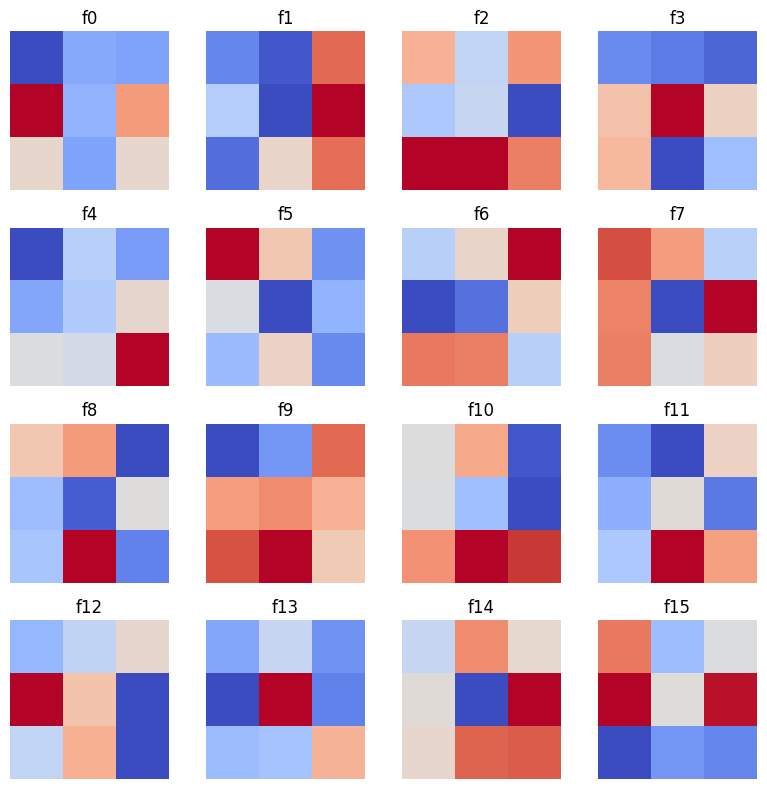

In [ ]:
visualize_filters(G, "block4.conv1")

中解像度（模様・リズム）模様の繰り返し・リズム・境界

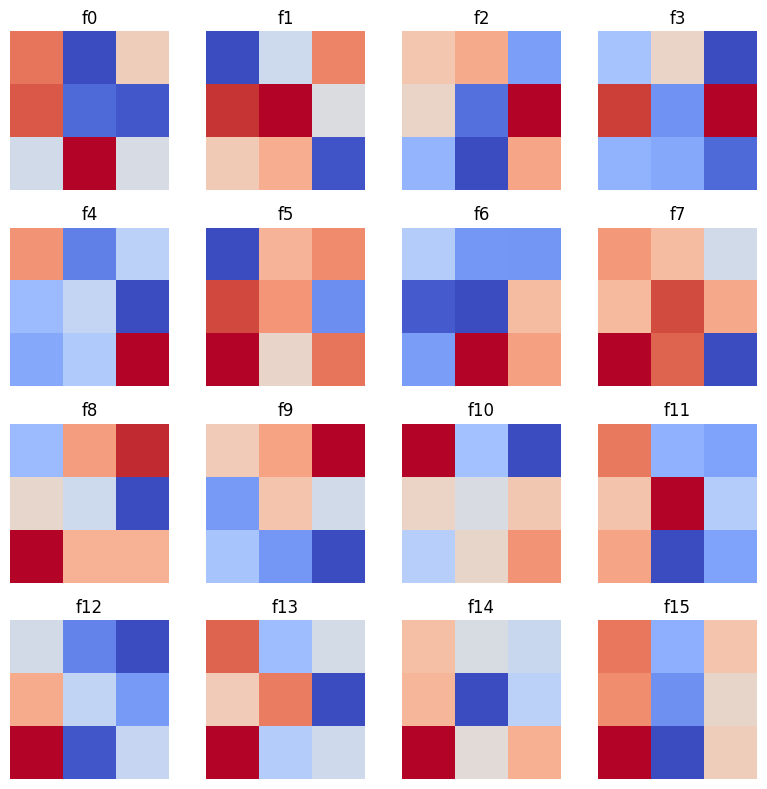

In [ ]:
visualize_filters(G, "blocks.32.conv1")

高解像度（質感・色のゆらぎ）色のにじみ、テクスチャ、細部

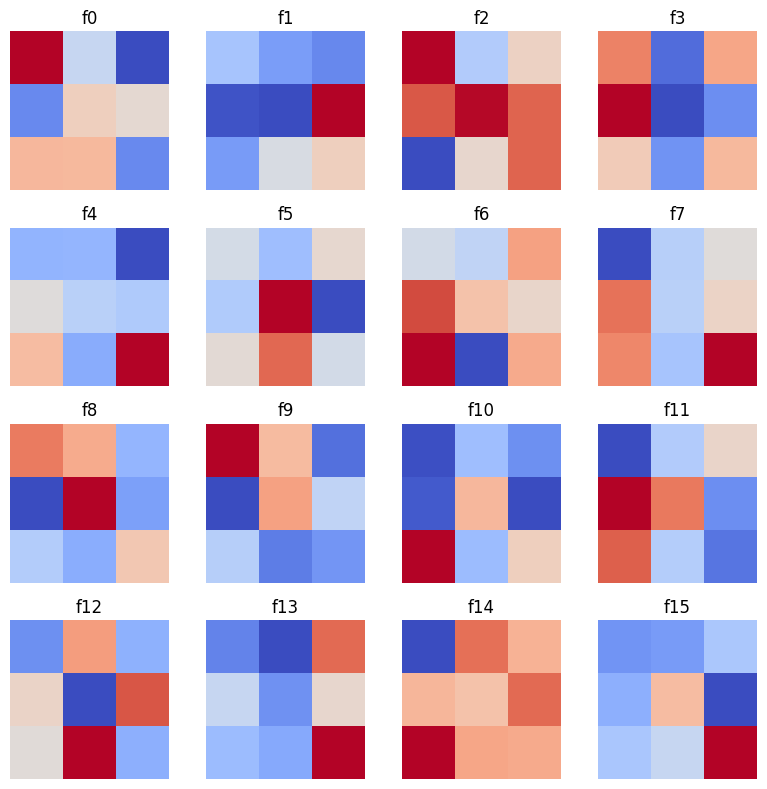

In [ ]:
visualize_filters(G, "blocks.128.conv2")

まず前提整理（いま見ているもの）

いま表示している図は何か
	•	各 Convフィルタの重み（kernel） をそのまま可視化したもの
	•	3×3 の小さなパターン
	•	これは 「何に反応したいかのテンプレート」 であって
「実際にどこに反応したか」ではない

つまり：

設計図（weight）を見ている段階
↓
次にやりたいのが「反応マップ（activation）」

「意味空間」を見たいなら、次にやるべきこと

この weight 可視化は 入口です。
意味を感じたいなら、次のどれかが効きます。

やりたいこと（あなたの質問）

特定フィルタが、生成画像のどの場所で強く使われているかを可視化したい

これはまさに Activation Map（特徴マップ）可視化 です

方法の全体像（PGGAN / Generator）.  
	1.	Generatorにフックを仕掛ける.  
	2.	特定のConv層の 出力特徴マップ を取得.  
	3.	1チャネル（= 特定フィルタ）を取り出す.  
	4.	ヒートマップとして表示.  
	5.	生成画像と並べて見る.  

フィルタ反応を取得するためのフック

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

② PGGAN Generator の特定層にフックを付ける.  

例：   
blocks["64"].conv1 の 最初のConv を見る場合.  
※ あなたのGでは：   
	•	blocks は ModuleDict.  
	•	key は "8" "16" "32" "64" ... の 文字列.  

In [ ]:
layer_name = "blocks.64.conv1"
layer = dict(G.named_modules())[layer_name]
layer.register_forward_hook(get_activation(layer_name))

③ 画像を1枚生成して、反応を取得

In [ ]:
G.eval()
z = torch.randn(1, 512).to(device)

with torch.no_grad():
    img = G(z, step=6, alpha=1.0)

In [ ]:
feat = activations[layer_name]
print(feat.shape)

torch.Size([1, 128, 64, 64])


④ 特定フィルタの反応マップを可視化

最大フィルタ数プリント

In [ ]:
print(layer.weight.size(0))

128


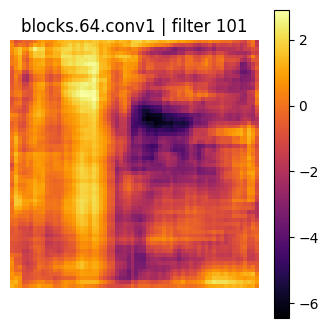

In [ ]:
import matplotlib.pyplot as plt

filt_idx = 101  # 見たいフィルタ番号
act = feat[0, filt_idx]  # [H, W]

plt.figure(figsize=(4,4))
plt.imshow(act, cmap="inferno")
plt.colorbar()
plt.title(f"{layer_name} | filter {filt_idx}")
plt.axis("off")
plt.show()

⑤ 元画像と並べて見る（重要）

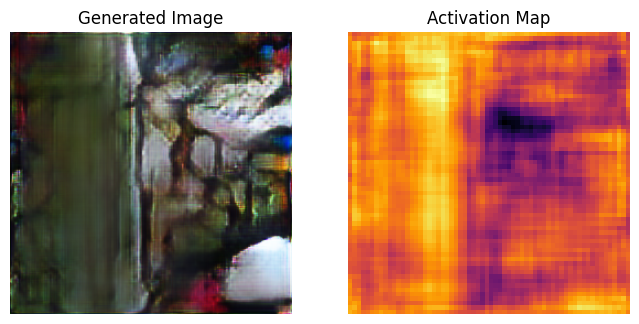

In [ ]:
img_np = (img[0].permute(1,2,0).cpu().numpy() + 1) / 2

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Generated Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(act, cmap="inferno")
plt.title("Activation Map")
plt.axis("off")

plt.show()

どう解釈すればよいか（超重要）

明るい場所 = そのフィルタが強く使われた場所
	•	広くぼんやり → 低周波（色・面）
	•	細い線状 → 輪郭・鉛線
	•	局所的な強い反応 → モチーフ的特徴（割れ目、交差、模様）

# PGGANの中間層特徴を使った PCA 移動コード

全体像（何をするか）.  
	1.	Generator の中間層の特徴マップをフックで取得.  
	2.	多数の z について中間特徴を集める.  
	3.	PCA で「よく変化する方向（意味軸）」を抽出.  
	4.	PCA の 第1軸・第2軸… に沿って潜在空間を移動.  
	5.	意味のあるアニメーションを得る.  
   
これは.  
👉 「ランダムウォーク」.  
👉 「1次元スキャン」.  
より ずっと意味が出やすい 方法です。   

STEP 1：中間層の特徴をフックで取得

まず、どの層を見るかを決めます。

PGGAN Generator なら、ここが良いです：
	•	block4
	•	blocks["32"]
	•	blocks["64"]
	•	blocks["128"]

まずは 32 or 64 をおすすめします（意味と構造のバランスが良い）。

フック用コード

In [ ]:
import torch

features = []

def hook_fn(module, input, output):
    # output: [B, C, H, W]
    features.append(output.detach().cpu())

STEP 2：フックを登録

例：blocks["64"] の conv1 の出力を取る

In [ ]:
layer = G.blocks["64"].conv1
hook = layer.register_forward_hook(hook_fn)

STEP 3：中間特徴を集める

In [ ]:
G.eval()
features.clear()

num_samples = 500   # 300〜1000くらいで十分
step = 6            # 256px
alpha = 1.0
device = "cuda"

with torch.no_grad():
    for _ in range(num_samples):
        z = torch.randn(1, 512, device=device)
        _ = G(z, step=step, alpha=alpha)

# フック解除
hook.remove()

# [N, C, H, W]
feat = torch.cat(features, dim=0)
print(feat.shape)

STEP 4：特徴を PCA 用に整形

空間方向を平均して 意味ベクトル化します。

In [ ]:
# [N, C]
feat_vec = feat.mean(dim=[2,3])
print(feat_vec.shape)

STEP 5：PCA をかける.  
	•	第1軸：一番「意味の強い変化」.  
	•	第2軸：次に強い意味.  

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
pca.fit(feat_vec.numpy())

print("Explained variance:", pca.explained_variance_ratio_)

STEP 6：PCA方向に沿って z を動かす.  

ここが 核心 です。   

PCA方向を「z空間」に投影する方法（簡易版）.  

厳密な逆写像は難しいので、   
「PCA軸で特徴が変わる z」を探す」 という実践的手法を使います。   

方法：平均との差分法（PGGANでよく使われる）.  

In [ ]:
# PCA第0軸
pc = torch.tensor(pca.components_[0], dtype=torch.float32)  # [C]

# z を2つ用意
z_base = torch.randn(1, 512, device=device)
delta = 0.05

def get_feature(z):
    features.clear()
    with torch.no_grad():
        _ = G(z, step=step, alpha=alpha)
    f = features[-1]           # [1,C,H,W]
    return f.mean(dim=[2,3])   # [1,C]

# 数値微分で z方向を推定
grad = torch.zeros_like(z_base)

for d in range(512):
    z1 = z_base.clone()
    z2 = z_base.clone()
    z1[0,d] += delta
    z2[0,d] -= delta

    f1 = get_feature(z1)
    f2 = get_feature(z2)

    diff = (f1 - f2).squeeze(0)   # [C]
    grad[0,d] = torch.dot(diff, pc) / (2*delta)

# 正規化
grad = grad / grad.norm()

この grad が
👉 「PCA第1軸に沿って意味が変わる z方向」

STEP 7：PCA軸でアニメーション生成

In [ ]:
out_dir = "latent_walk_pca_axis0"
os.makedirs(out_dir, exist_ok=True)

N = 300
scale = 5.0

with torch.no_grad():
    for i in range(N):
        t = (2*i/(N-1) - 1) * scale
        z = z_base + t * grad
        img = G(z, step=step, alpha=alpha)
        save_image(
            img,
            f"{out_dir}/frame_{i:04d}.png",
            normalize=True,
            value_range=(-1,1)
        )

この方法で何が起きるか
	•	意味が急に立ち上がる
	•	色・構造・リズムが 一貫して変化
	•	「どの次元でも同じ」に見える問題が激減

あなたがさっき見ていた

どの次元も似た画像になる

という現象は：

z の各軸が「意味軸」として独立していない

からです。
PCAは「意味の混ざった軸」を解きほぐす操作です。

C. PCA / 固有方向移動（←次にやるべき）
	•	潜在空間の「よく使われている方向」
	•	学習データ由来の変化が出やすい

→ “学習対象らしさ”を保った変化

これは、

「元の高解像度映像に ありそう な変化」

に一番近づきます。

⸻

D. 多次元のゆっくりしたカーブ移動（おすすめ）
	•	z(t) を直線でなく
低周波カーブ / 円 / スプラインで動かす
	•	各次元の速度を変える

→ 呼吸・うねり・流体的なアニメーション

あなたの Breathing X 的感覚とも相性がいい